# Machine Learning Triangles (R)
# Introduction

In this article we look at applying different machine learning (ML) models to a data set.
Our goal is to illustrate a work flow for:

-   setting up a data set for ML
-   applying different ML models to this data
-   tuning the ML hyper-parameters
-   comparing and contrasting performance for the past fitted values and the future predictions.

A secondary goal is to demonstrate the utility of a multi-model machine learning framework which enables the user to easily "plug and play" different machine learning models within the same framework. We use the **mlr3** set of packages in R here - this and other similar packages in R (e.g. **caret** and **tidymodels**) and tools in **scikit-learn** in python may be useful in creating a smoother work flow.

A [notebook version of this article](/mlr-blog/f_notebooks/ML modelling on triangles - a worked example.html) is also available which may be helpful if you want to experiment with this code. 

## Who is this article aimed at?

This article is aimed at those who know a little about some of the standard machine learning models, but who may not have done much hands-on work with an analysis. It will also be useful for those who have done some experimentation, but maybe not on a reserving data set. Finally, it may also be of interest to R users who have never used a multi-model framework before and who would like to see how the **mlr3** ecosystem works.

## Pre-requisites to this article

We've tried to make this article accessible to people new to ML, and to make this article stand-alone. Having some knowledge about basic machine learning techniques like decision trees, random forests and XGBoost (gradient boosting) will help. Furthermore, we also fit the Chainladder model as a GLM (sometimes referred to as a Stochastic Chainladder) and fit a particular type of LASSO model. We've included limited details on these models here - our previous blog posts have more details on these:

* [Reserving with GLMs](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/glms/)
* [Self-assembling claim reserving models using the LASSO](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-lasso/)

## The data set

Our example deals with using ML to set reserves for a single aggregate 40x40 triangle. We've selected the data set because:

* It's small, so the code will run relatively quickly on your machine - there's nothing worse than running through a worked example and having to wait hours for results!
* A lot of reserving is still done using traditional accident (or underwriting) + development aggregated triangles so it is relevant to the real world.

We use a simulated data set. There are several reasons for this:

* We know the future results so can examine how different reserve predictions perform.
* We can control how the future experience emerges. In particular, we can ensure there are no future systemic changes (e.g. from legislation or court precedent) that would impact future payments. Changes like this can make it difficult when examining performance of reserve prediction methods on real data - it can be hard to separate poor performance of the model from a good model where the future experience departs markedly from that used to build the model.
* We can share the data set (and the code to generate it) with you.

The data set used is simulated data set 3 from the paper [Self-assembling insurance claim models using regularized regression and machine learning](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906). This is a 40x40 triangle of incremental quarterly payments over 10 years. Variables on the data set are accident, development and calendar quarters only. A copy of the data set is available [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata3.csv).

## Machine learning and aggregate triangles

Typically, ML and big data go hand-in-hand. By big data we mean lots of observations and lots of features (covariates / independent variables / regressors). Aggregate triangles are small in both senses - small numbers of observations and limited features (often just the 3 time features of accident/underwriting period, development period and calendar period).

This is not to say that it is invalid to use machine learning for aggregate triangles - many people have demonstrated good results from machine learning for such data - there are many papers on this topic. But it's also true that an experienced actuary using a Chainladder model (or other traditional) method, overlaid with judgement, will often get a similar answer to the best ML method, even for a complex triangle. However ML may be a more efficient way of getting to an answer. In the worked example below, we use a data set which deviates significantly from Chainladder assumptions. Therefore the unadjusted Chainladder projection is quite poor and would need a significant investment of time to yield a better model. In contrast, the better performing ML models we looked at have a better first estimate, so may not require as much intervention to produce a final estimate, thereby leading to a time-saving.

## Don't rank the ML models used based on this example

The purpose of this article is to demonstrate a workflow for fitting ML models in R. While we've done some work to improve model fitting, there are a lot more things we would consider if we were looking for the best models (e.g. feature engineering, train/test splits, performance measures). So, although we do look at the relative performance of the different models at the end, you should not make any conclusions about the relative performance of the different ML methods based on this work.

You may find that by adjusting some hyper-parameters, or by revising the training/test data set split, you're able to find better models. 
We'll be discussing this point a bit further at the end of the article.

*A priori*, given the form of the data (simulated using a regression style structure) and that the LASSO model we used is based on previous work which did aim to establish a framework to fit good models to triangular data using the LASSO, we expected that the LASSO model would perform the best and (spoiler alert!) it did.

## mlr3 package

One problem with applying many different types of ML models is that they all generally have different input specifications for the data, and different output types. This can make it a bit tedious to try several models. 

There are a number of ML aggregator or multi-model packages that do a lot of the data manipulation behind the scenes. These packages take in data in a specified form and allow users to call the different ML methods. They abstract away any data manipulation required to put the data into the form required by the method. The benefit of these is apparent - set up the data in the aggregator and then switch models in and out at will.

One of our [previous articles](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/topten-r-packages/) covers multi-model packages.  

Some ML aggregators in R include

* [caret](https://cran.r-project.org/web/packages/caret/index.html)
* [tidymodels](https://www.tidymodels.org/) - a successor to caret. 
* [mlr3](https://mlr3.mlr-org.com/) is the successor to the popular but no longer actively developed [mlr](https://mlr.mlr-org.com/).

The Python package **scikit-learn** also provides a lot of useful machine learning tools.

If you're looking to use an aggregator package then it's probably best to read up on a few of them, then select the one that best works for you.
We picked **mlr3** first because one of us has used **mlr** in the past and second we are part of the **M**achine **L**earning in **R**eserving working party, so we had to give **mlr3** a try!

**mlr3** uses the R6 object orientated classes - R6 is similar to object orientated programming in other languages such as Python or C++, but is quite different to R's S3 and S4 object orientated approaches. So, depending on your programming experience, the syntax may take a bit of getting used to.

As a rough rule of thumb, when working with R6 classes we:

* First set up an instance of the class. Note that the class can contain both methods (like functions) and data.
* We then run methods for the class object. These may update the data in the object.
* We can view and use the data in the class object. Sometimes we can edit the data directory, othertimes, the data is read only and can only be modified using a method (function) available in the class object.

If you want to learn more there is plenty of documentation out there:

* The [mlr3 book](https://mlr3book.mlr-org.com/)
* [Cheatsheets](https://cheatsheets.mlr-org.com/)
* [Gallery of examples](https://mlr3gallery.mlr-org.com/)

When using **mlr3** code, then you can get inline help in R by using the `help()` method in a class object. This will bring you to help pages.
E.g. `lrn("regr.rpart")$help()` with get you help on decision tree learners and the learner object in general.

In our worked example below, we aim to explain each step clearly, so if you prefer to use another package (or language) or work separately with the individual ML packages, you should be able to translate what we are doing into code that is more familiar to you.


## ML methods used

We've looked at the following methods:

* Decision trees
* Random forests
* XGBoost
* LASSO

We also use a GLM which is set up to replicate the Chainladder estimates (refer to this [post](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/glms/) for more details).

An obvious omission from here are neural networks / deep learning models. We've omitted these for a couple of reasons:

* We're using **mlr3** here. While there is a [**mlr3keras**](https://github.com/mlr-org/mlr3keras) package, the developers state (as of May 2021) that *mlr3keras is in very early stages, and currently under development. Functionality is therefore experimental and we do not guarantee correctness, safety or stability*.
* The setup for **mlr3keras** is more difficult as it requires having an instance of Python running on your system. R's **reticulate** package then interfaces between the two. Sometimes this is straightforward (some recent improvements have made this a lot easier), but other times it can be frustrating.

However, we are actively looking at using deep learning models and will be revisiting them in the near future.

# Outline of the workflow

The workflow we have set up consists of the following:

* Prepare the data for use in the models, including train and test partitions (past data) and hold-out or validation partitions (future data).
* Fit each of the models selected. For each of these we:
  + Select hyper-parameters (these control the model-fitting process) for tuning
  + Tune the hyper-parameters using the train and test partitions and select the set of values that yield the best results
  + Calculate predicted values on the holdout (future) data.
* Run diagnostics on the predicted values for each model and look at the reserve estimates.

We'll now work through each of the stages below.

# Setup

The first step is to load all the libraries required for this work (and install them first if needed).
We've included details of our session which includes versions of the packages we used at the end of this article.
If you are having problems running our code, check that your packages (the mlr3 ones in particular) are the same as ours.

Note that **mlr3** is actually a collection of a number of different packages. If you want to do a specific task, it's worth seeing if there is an **mlr3** package out there for it.
There are a number of core **mlr3** packages which are hosted on CRAN. 
We've attached them separately here to make it clear which ones we are using but it is also possible to install and attach the most commonly used ones via the [mlr3verse](https://cran.r-project.org/web/packages/mlr3verse/index.html) wrapper package.

Some of the accompanying packages are on github only.
Of these, we're just going to use one here - **mlr3extralearners** - which contains an extended set of machine learning models (the CRAN package **mlr3learners** includes the most common ones). 
Install this using the **remotes** package - the code is given below in the comments.

You also need to have the following packages installed - but you do not need to attach them as a library:

* **glmnet** (for the LASSO model)
* **rpart** (decision tree)
* **ranger** (random forest)
* **xgboost** 
* **viridis** (colour schemes used in some of the plots).

Finally you need to install **mlr3measures** but you **must not** attach it (i.e. use `library(mlr3measures)`) as this will lead to code errors.

The code below checks for these packages and will give you a warning message if you are missing any of them. You can then install them (with the exception of **mlr3extralearners**) with `install.packages()` or, for RStudio users, via the Packages tab.


In [1]:

reqd_packages <- c("data.table",
                   "ggplot2",
                   "glmnet",
                   "kableExtra",
                   "IRdisplay",
                   "mlr3",
                   "mlr3extralearners",
                   "mlr3learners",
                   "mlr3measures",
                   "mlr3tuning",
                   "paradox",
                   "patchwork",
                   "ranger",
                   "remotes",
                   "rpart",
                   "rpart.plot",
                   "viridis",
                   "xgboost")


for (p in reqd_packages){
  check_p <- requireNamespace(p, quietly = TRUE)
  if (!check_p) warning(paste("Install the package", p, "before continuing\n"))
}

message("Package checking complete\n")
                   

# To install packages via code:
# install.packages(<package name>) 

# To install mlr3extralearners (which is not on CRAN so must be installed on github)
# 1. Ensure you have the remotes package installed
# 2. install using
#     remotes::install_github("mlr-org/mlr3extralearners")
#
# if this fails (e.g. if you are using renv to manage packages then it might), you may need to use
# remotes::install_github("mlr-org/mlr3extralearners", INSTALL_opts = c("--no-multiarch") )
# see https://github.com/rstudio/renv/issues/162




Package checking complete




Now that we've checked the required packages are there, we can get started with the example by attaching the libraries we require.


In [2]:

# machine learning libraries
library(mlr3)   # base mlr3 package
library(mlr3learners)  # implements common learners
library(mlr3tuning)    # tuning methodology
library(paradox)   # used to create parameter sets for hyperparameter tuning
library(mlr3extralearners) # needed for glms

# data manipulation
library(data.table)

# graphing
library(ggplot2)  # plotting
library(patchwork) # easy way to combine ggplots
library(rpart.plot)   # to draw decision trees created by rpart

# making nice tables
library(kableExtra)
library(IRdisplay) # displays tables when in ipynb format

# stop R from showing big numbers in scientific notation
options("scipen"=99)  


# colours for plots - not all are used
# We will also use viridis for some plots
dblue  <- "#113458"
mblue  <- "#4096b8"
gold   <- "#d9ab16"
lgrey  <- "#dcddd9"
dgrey  <- "#3f4548"
black  <- "#3F4548"
red    <- "#d01e45"
purple <- "#8f4693"
orange <- "#ee741d"
fuscia <- "#e9458c"
violet <- "#8076cf"




Loading required package: paradox


Attaching package: ‘mlr3extralearners’


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: rpart



# Data preparation

We're using a simulated data triangle with all values (past and future).


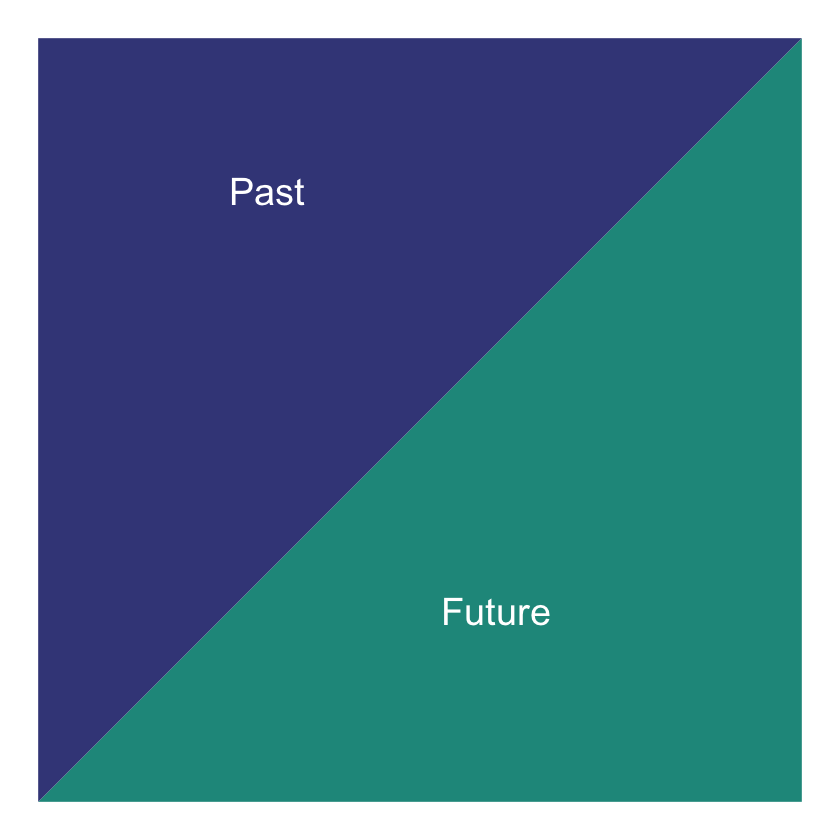

In [3]:
tri <- rbind(data.table(x=c(0, 0, 10), y=c(0, 10, 10), group=c("train", "train", "train")),
             data.table(x=c(0, 10, 10), y=c(0, 10, 0), group=c("test", "test", "test")) )

ggplot(data=tri, aes(x=x, y=y, fill=group)) +
  geom_polygon(aes(group = group)) +
  #scale_fill_viridis_d(alpha=1, begin=0.2, end=0.7, direction=-1) +
  scale_fill_manual(values=c("#1F968BFF", "#404788FF"))+
  theme_void() +
  annotate(geom="text", label="Past", x=3, y=8, size=8, colour="white") +
  annotate(geom="text", label="Future", x=6, y=2.5, size=8, colour="white") +
  theme(legend.position = "none")


The data set we use is the simulated data set 3 from this [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906).
It is available in CSV form [here](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata3.csv).

This is a 40x40 triangle of payments:

* That vary by accident quarter
* That vary by development quarter
* Have varying rates of superimposed inflation in payment size by calendar quarter (including no inflation)
* Have a step-up in payment size for accident quarters > 16 and development quarters > 20.

The first two effects are captured by a Chainladder model but the last two effects depart from Chainladder assumptions.

## data.table package

We'll be using the **data.table** package for manipulating the data. There's an introduction to **data.table** on our [blog](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/datatable/) if you are unfamiliar with it.
If you see `:=` in the R code, then that's **data.table** assignment.
(Actually in the code chunks you may see an underscore under the `:=` - this is inserted by the formatting we are using to prepare the notebook for some reason, so please ignore the underscore).

## Load the data

First, load in the data and have a look at it.

In [4]:

dat <- fread("https://institute-and-faculty-of-actuaries.github.io/mlr-blog/csv/lasso_simdata3.csv")

head(dat)
tail(dat)

# create the num_periods variable - number of acc/dev periods
num_periods <- dat[, max(acc)]


pmts,acc,dev,cal,mu,train_ind
<dbl>,<int>,<int>,<int>,<dbl>,<lgl>
242671.2,1,1,1,71653.13,TRUE
164001.3,1,2,2,1042775.62,TRUE
3224477.8,1,3,3,4362599.77,TRUE
3682530.8,1,4,4,10955670.09,TRUE
10149368.6,1,5,5,20800545.12,TRUE
28578274.7,1,6,6,33089166.75,TRUE


pmts,acc,dev,cal,mu,train_ind
<dbl>,<int>,<int>,<int>,<dbl>,<lgl>
125261750,40,35,74,109039367,FALSE
62657370,40,36,75,82853302,FALSE
63467681,40,37,76,62682720,FALSE
26041979,40,38,77,47227843,FALSE
33947274,40,39,78,35444881,FALSE
37258687,40,40,79,26503298,FALSE


As you can see, the data is not in triangular form as per the diagram above, but is instead in long form where:

* each row of the data set consists of one observation
* each observation has the accident(`acc`), development(`dev`) and calendar(`cal`) period associated with it
* the `mu` value is the mean value of the distribution from which `pmts` was simulated - this won't form part of the analysis below so can be ignored
* the final variable, `train_ind` is `TRUE` for past values and `FALSE` for future values.

This long format of data is standard for a lot of modelling and data analysis.

We can also show a visualisation of the data. This contains both past and future data (with a diagonal line marking the boundary). The plot uses shading to indicate the size of the payments (specifically, log(payments)).
The step-up in claim size (acc > 16 and dev > 20) is quite obvious in this graphic. What is also apparent is this this increase only affects a small part of the past triangle (10 cells out of 820 to be exact), but impacts much of the future lower triangle.

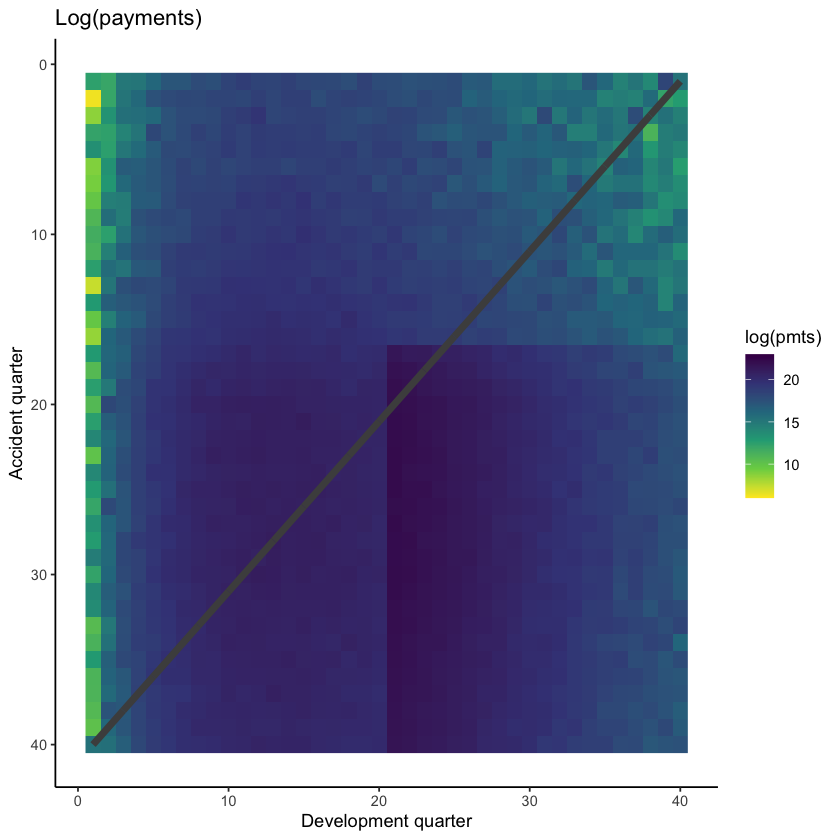

In [5]:

# get limits for use with raster plots
data_raster_limits <- c(floor(dat[, min(log(pmts))]), ceiling(dat[, max(log(pmts))]))

ggplot(dat, aes(dev, acc)) +
  geom_raster(aes(fill = log(pmts)))+
  geom_line(aes(x=num_periods+1-acc, y=acc), colour="grey30", size=2)+
  scale_y_reverse()+
  scale_fill_viridis_c(begin=1, end=0, limits=data_raster_limits)+
  theme_classic()+
  labs(x="Development quarter", y="Accident quarter", title="Log(payments)")+
  NULL



The step-up in payments can be modelled as an interaction between accident and development quarters.
Because it affects only a small number of past values, it may be difficult for some of the modelling approaches to capture this.
It's likely, therefore, that the main differentiator between the performance of different methods for this data set will be how much well they capture this interaction.

One thing to note is that the Chainladder will struggle with this data set. Both the calendar period terms and the interaction are not effects that the Chainladder can model - it assumes that only accident and development period main effects (i.e. no interactions) are present. So an actuary using the Chainladder for this data set would need to overlay judgement to obtain a good result.

We need to modify this data a little before proceeding further:

* We'll add factor versions (essentially a categorical version) of acc and dev - these are needed later for fitting the Chainladder
* We'll add a unique ID associated with each row


In [6]:

# data.table code, := is assignment
# if you see an underscore under the := in the code below, then this is a formatting thing - ignore the underscore here and elsewhere
# the code should look like this: dat[, accf := as.factor(acc)]
dat[, accf := as.factor(acc)]
dat[, devf := as.factor(dev)]


# data.table code, .N = number of rows
dat[, row_id := 1:.N]

tail(dat)


pmts,acc,dev,cal,mu,train_ind,accf,devf,row_id
<dbl>,<int>,<int>,<int>,<dbl>,<lgl>,<fct>,<fct>,<int>
125261750,40,35,74,109039367,FALSE,40,35,1595
62657370,40,36,75,82853302,FALSE,40,36,1596
63467681,40,37,76,62682720,FALSE,40,37,1597
26041979,40,38,77,47227843,FALSE,40,38,1598
33947274,40,39,78,35444881,FALSE,40,39,1599
37258687,40,40,79,26503298,FALSE,40,40,1600


## Create a mlr3 task

Now create an **mlr3** [task](https://mlr3book.mlr-org.com/tasks.html) - making an object to hold data and set roles for the data.
These tasks abstract away (i.e. do it for you) all the hard work in getting the data into the right form for each model (learner in **mlr3** parlance) - just specify what the target is and what the features are, and **mlr3** will take care of the rest. 

We need to make a regression task since we will be estimating payments. So we make a new instance of the `TaskRegr` class via `TaskRegr$new`.
When loading the data in via the `backend`, we've omitted `mu` since this is not used in the modelling. 
We've also omitted the factor versions of `acc` and `dev`.

In [7]:
# note can also use the sugar function tsk()
task <- TaskRegr$new(id = "reserves",
                     backend = dat[, .(pmts, train_ind, acc, dev, cal, row_id)],
                     target = "pmts")

# look at the task
task

<TaskRegr:reserves> (1600 x 6)
* Target: pmts
* Properties: -
* Features (5):
  - int (4): acc, cal, dev, row_id
  - lgl (1): train_ind

We need to ensure everything is correctly assigned:

* Future data must not be used for model training. Currently all parts of the triangle are used because we loaded all the data into the `backend`.
* The right features must be used in model training. Right now `row_id` and `train_ind` are also included in the features which is incorrect.

For the first, we'll use `row_roles` to ensure that future data is not used for model training.
There are two types of `row_roles` - `use` and `validation`. Right now all rows are in `use`.

In [8]:

# number of entries in use
print(length(task$row_roles$use))

# for brevity just print first 10 elements
print(task$row_roles$use[1:10])

# number of entries in validation
print(length(task$row_roles$validation))



[1] 1600
 [1]  1  2  3  4  5  6  7  8  9 10
[1] 0


Move all future values (`train_ind==FALSE`) into `validation` so they are not used in the model.

We can't edit row_roles directly, so use the method (`set_row_roles()`) to do this. Supply the list of future row_ids in the first argument.

In [9]:

task$set_row_roles(dat[train_ind==FALSE, row_id], roles="validation")


Check that the task has been updated correctly.

In [10]:

# number of entries in use
print(length(task$row_roles$use))

# for brevity just print the end of the second accident period - row id 80 should be in validate
print(task$row_roles$use[70:90])

# number of entries in validation
print(length(task$row_roles$validation))
print(task$row_roles$validation[1:10])



[1] 820
 [1] 70 71 72 73 74 75 76 77 78 79 81 82 83 84 85 86 87 88 89 90 91
[1] 780
 [1]  80 119 120 158 159 160 197 198 199 200


This looks right (we've checked more than this, but have limited what we display in this notebook).

Now we need to remove `row_id` and `train_ind` from the list of features:

* we'll ignore `train_ind` (so it won't have any role)
* we'll set `row_id` to be a name. This could be used in plots to label points if needed.

In [11]:
# make row_id a name
task$set_col_roles("row_id", roles="name")

# drop train_ind from the feature list
task$col_roles$feature <- setdiff(task$feature_names, "train_ind")  

# check the task has the correct variables now
task

# check alll the col_roles
task$col_roles

<TaskRegr:reserves> (820 x 4)
* Target: pmts
* Properties: -
* Features (3):
  - int (3): acc, cal, dev

$feature
[1] "acc" "cal" "dev"

$target
[1] "pmts"

$name
[1] "row_id"

$order
character(0)

$stratum
character(0)

$group
character(0)

$weight
character(0)

$uri
character(0)

# Tuning process for hyper-parameters

Machine learning models have a number of hyper-parameters that control the model fit.
Tweaking the hyper-parameters that control model fitting (e.g. for decision trees, the depth of the tree, or for random forests, the number of trees to average over) can have a significant impact on the quality of the fit. 
The standard way of doing this is to use a train and test data set where:

* The model is trained (built) on the train data set
* The performance of the model is evaluated on the test data set
* This is repeated for a number of different combinations of hyper-parameters, and the best performing one is selected.

Evaluating the models on a separate data set not used in the model fitting helps to control over-fitting.
Usually we would then select the hyper-parameters that lead to the best results on the test data set and use these to predict our future values.

There are various ways we can select the test and train data sets.
For this work we use cross-validation. We'll give a brief overview of it below. 
Note that we will be discussing validation options in a separate article. 


## Cross-validation

The simplest implementation of a train and test partition is a random one where each point in the data set is allocated to train and test at random.
Typically, the train part might be around 70-80% of the data and the test part the remainder.



In [12]:

tri <- rbind(data.table(x=c(0, 0, 10), y=c(0, 10, 10), group=c("past", "past", "past")),
             data.table(x=c(0, 10, 10), y=c(0, 10, 0), group=c("future", "future", "future")) )

# # draw plot of past data
# p1 <- ggplot(data=tri[group=="past",], aes(x=x, y=y, fill=group)) +
#   geom_polygon(aes(group = group)) +
#   geom_polygon(aes(group = group), fill="#404788FF") +
#   theme_void() +
#   annotate(geom="text", label="Payments triangle", x=3, y=8, size=8, colour="white") +
#   theme(legend.position = "none")
# 
# # kept 
# # holdout as last diagonal
# tri1 <- rbind(data.table(x=c(0, 0, 8), y=c(2, 10, 10), group=c("train", "train", "train")),
#              data.table(x=c(0, 0, 8, 10), y=c(0, 2, 10, 10), group=c("test", "test", "test", "test")) )
# 
# p2 <- ggplot(data=tri1, aes(x=x, y=y, fill=group)) +
#   geom_polygon(aes(group = group)) +
#   #scale_fill_viridis_d(alpha=1, begin=0.2, end=0.75, direction=-1) +
#   scale_fill_manual(values=c("#73D055FF", "#404788FF"))+
#   theme_void() +
#   annotate(geom="text", label="Train", x=3, y=8, size=6, colour="white") +
#   annotate(geom="text", label="Test", x=3, y=4, size=6, colour="white") +
#   theme(legend.position = "none")

# scattered throughout
sq <- list()
sq[[1]] <- data.table(x=c(0, 0, 1, 1), y=c(1, 2, 2, 1), group=rep("test", 4))
sq[[2]] <- data.table(x=c(1, 1, 2, 2), y=c(8, 9, 9, 8), group=rep("test", 4))
sq[[3]] <- data.table(x=c(3, 3, 4, 4), y=c(5, 6, 6, 5), group=rep("test", 4))
sq[[4]] <- data.table(x=c(8, 8, 9, 9), y=c(9, 10, 10, 9), group=rep("test", 4))
sq[[5]] <- data.table(x=c(6, 6, 7, 7), y=c(7, 8, 8, 7), group=rep("test", 4))
sq[[6]] <- data.table(x=c(0, 0, 1, 1), y=c(4, 5, 5, 4), group=rep("test", 4))
sq[[7]] <- data.table(x=c(2, 2, 3, 3), y=c(3, 4, 4, 3), group=rep("test", 4))
sq[[8]] <- data.table(x=c(4, 4, 5, 5), y=c(8, 9, 9, 8), group=rep("test", 4))



p3 <- ggplot(data=tri[group=="past",], aes(x=x, y=y, fill=group)) +
  geom_polygon(aes(group = group), fill="#404788FF") +
  theme_void() +
  theme(legend.position = "none") +
  annotate(geom="text", label="Train", x=2, y=6, size=6, colour="white") +
  NULL

for(i in 1:length(sq)){
    p3 <- p3 + geom_polygon(dat=sq[[i]], aes(x=x, y=y, fill=group), fill="#73D055FF")
}


p3 <- p3 + annotate(geom="text", label="Test", x=6.5, y=7.5, size=6, colour="white")


**Random test data set**

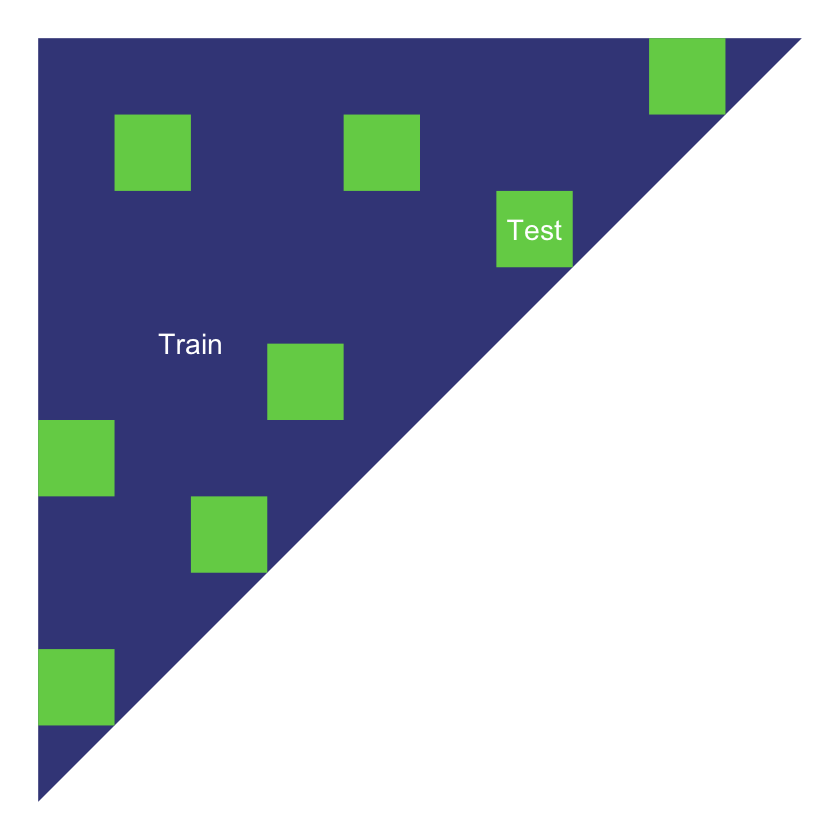

In [13]:
p3

Cross-validation repeats this type of split a number of times.

In more detail, the steps are:

* Randomly partition the data into *k* equal-sized folds (between 5-10 folds are common choices). These folds are then fixed for the remainder of the algorithm. 
  + This means that we do a train/test split like the triangle above but repeat this *k* times.
* Fit the model using data from *k*-1 of the folds, using the remaining fold as the test data. Do this *k* times, so each fold is used as test data once.
* Calculate the performance metrics for each model on the corresponding test fold.
* Average the performance metrics across all the folds.

A simplified representation of the process is given below. 

**5-fold cross validation**

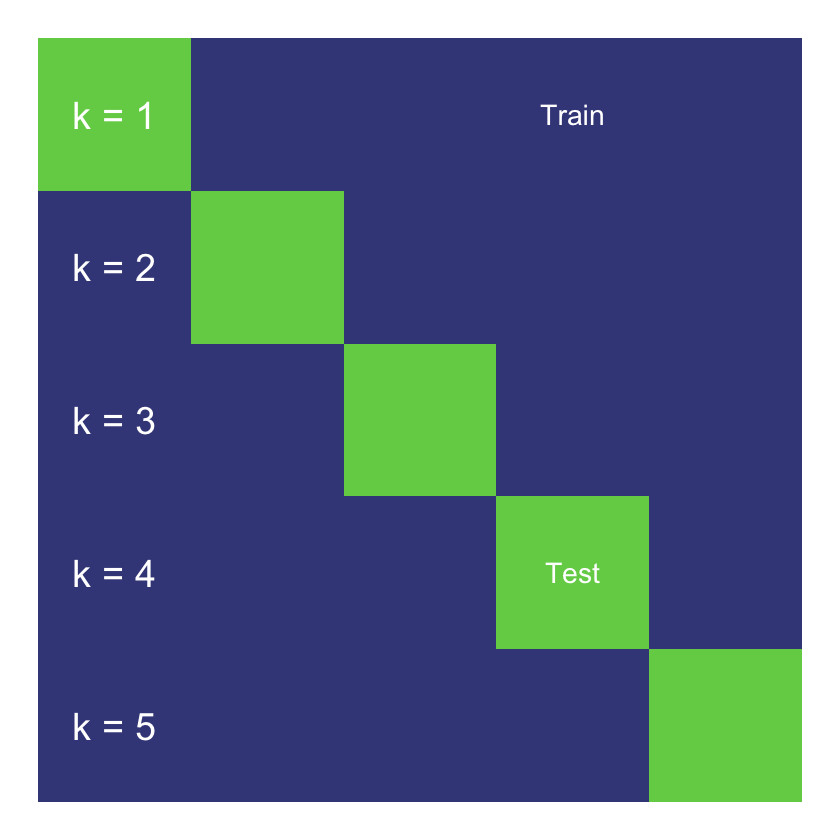

In [14]:
# draw the graph

p <- ggplot() 

# rectangles
for (i in 0:4){
  for (j in 0:4){
    if(i != (4-j)) p <- p + annotate(geom="rect", xmin=i, xmax=i+1, ymin=j, ymax=j+1, fill="#404788FF", alpha=1) 
  }
}

# grid lines - second so they appear on top
for (i in 0:4){
  p <- p + 
    annotate(geom="rect", xmin=i, xmax=i+1, ymin=5-i, ymax=5-i-1, fill="#73D055FF", alpha=1) +
    annotate(geom="text", x=0.5, y=5-i-0.5, size=8, colour="white", label=paste("k =", i+1))
}

p <- p + 
  theme_classic() +
  theme_void() +
  annotate(geom="text", label="Train", x=3.5, y=4.5, size=6, colour="white") +
  annotate(geom="text", label="Test", x=3.5, y=1.5, size=6, colour="white") 


p

Cross-validation provides an estimate of out-of-sample performance even though all the data is used for training and testing. 
It is often considered more robust due to its use of the full dataset for testing, but can be computationally expensive for larger datasets. Here we only have a small amount of data, so there is an advantage to using the full dataset, whilst the computational cost is manageable. 

## Setting up cross-validation in mlr3

We can set up a cross-validation resampler in mlr3 that can then be applied to any model. As always, the [book](https://mlr3book.mlr-org.com/resampling.html) is a useful starting reference point.

Here we will use 6-fold cross validation. 


In [15]:

# create object
crossval = rsmp("cv", folds=6)  


set.seed(42)  # reproducible results

# populate the folds
# NB: mlr3 will only use data where role was set to “use”
crossval$instantiate(task)   


Below we show the allocation of points into test and train for each fold - the dark blue points are the test subset in each of the 6 folds.

In [16]:

# interaction x >= 17 && y >= 21

xydat <- data.table(acc = rep(1:num_periods, each = num_periods),
                    dev = rep(1:num_periods, times = num_periods),
                    row_id = 1:nrow(dat) )
                      
xydat[, past := TRUE][((acc+dev-1) > num_periods), past := FALSE]


# add first test and train data set
nf <- crossval$iters  # number of folds

for (i in 1:nf){
  tem <- rbind(
    data.table(row_id = (crossval$train_set(i)), train_ind = TRUE),
    data.table(row_id = (crossval$test_set(i)), train_ind = FALSE)
  )
  
  setkey(tem, row_id)
  
  nm <- paste0("fold", i)
  xydat[tem, on=.(row_id), (nm) := i.train_ind]
}

# drop the future data now
xydat <- xydat[past==TRUE,]

# make a long data set now so we can ggplot it
folds <- melt(xydat,
              measure.vars = paste0("fold", 1:nf),
              id.vars = c("acc", "dev"))





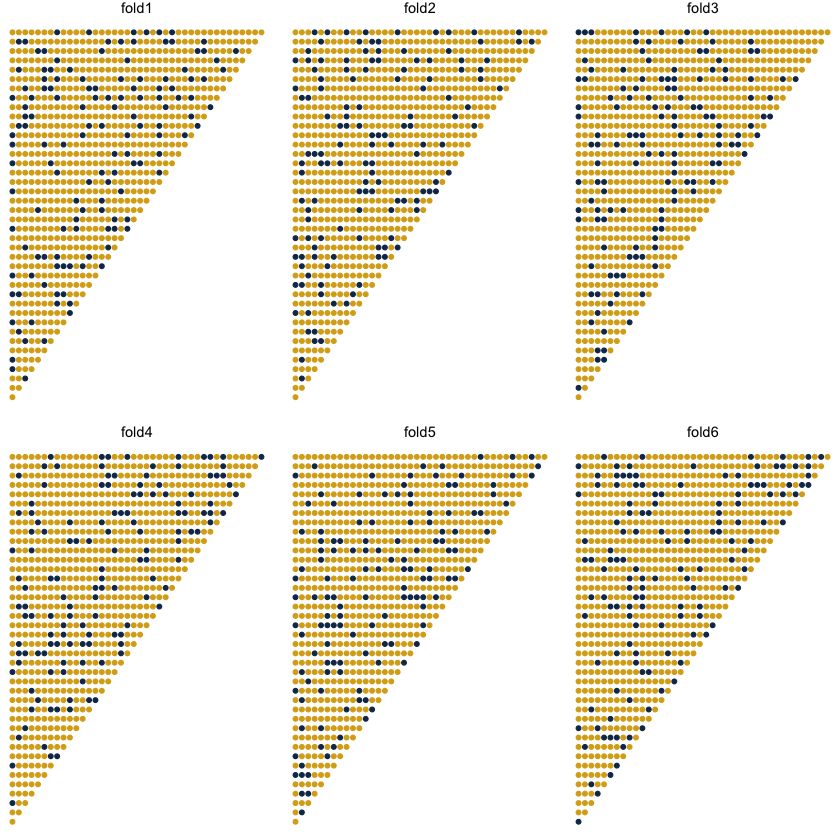

In [17]:

ggplot(data=folds, aes(x=dev, y=acc, colour=value)) +
  facet_wrap(~variable, ncol=3)+
  geom_point(size=1) +
  scale_colour_manual(values=c(dblue, gold)) +
  scale_y_reverse() +
  theme_void() +
  theme(legend.position = "none") +
  NULL  



## Performance measure

As well as the cross-validation process, we want to set up a performance measure to use.
Here we will use RMSE (root mean square error).

In [18]:
# to see all measures use 
# mlr_measures$help()
# follow the links for a specific one, or you can type
# ?mlr_measures_regr.rmse to get help for RMSE, and then insert the 
# other names for others, eg ?mlr_measures_regr.rmsle etc

measure <- msr("regr.rmse")


## Searching hyper-parameter space

Searching hyper-parameter space needs to be customised to each model, so we can't set up a common framework here.
However, to control computations, it is useful to set a limit on the number of searches that can be performed in a tuning exercise.
**mlr3** offers a number of different options for terminating searches - here we are just going to use the simplest one - where only a limited number of evaluations are permitted.

Given how we set up the tuning process below we need 25 evaluations for the decision tree and random forest models. We need many more evaluations for the XGBoost model since we tune more parameters. However, this can take a long time to run. In practice, using a more powerful computer, or running things in parallel can help.

So we've set the number of evaluations to a low number here (25). For the XGBoost model, we used 500 evaluations to tune the hyper-parameters and saved the results for use here.


In [19]:

# setting we used to get the xgboost results below
#evals_trm = trm("evals", n_evals = 500)

# using a low number so things run quickly
evals_trm = trm("evals", n_evals = 25)


# Fitting some ML models

Now it's time to fit and tune the following ML models using **mlr3**:

* Decision tree 
* Random forest
* XGBoost

## Decision tree

A decision tree is unlikely to be a very good model for this data, and tuning often doesn't help much.
Nonetheless, it's a simple model, so it's useful to fit it to see what happens.

To illustrate the use of mlr3, we'll first show how to fit a model using the default hyper-parameters.
We'll then move onto the code needed to run hyper-parameter tuning using cross-validation.

### Fitting a single model

First let's fit a decision tree using default parameters.


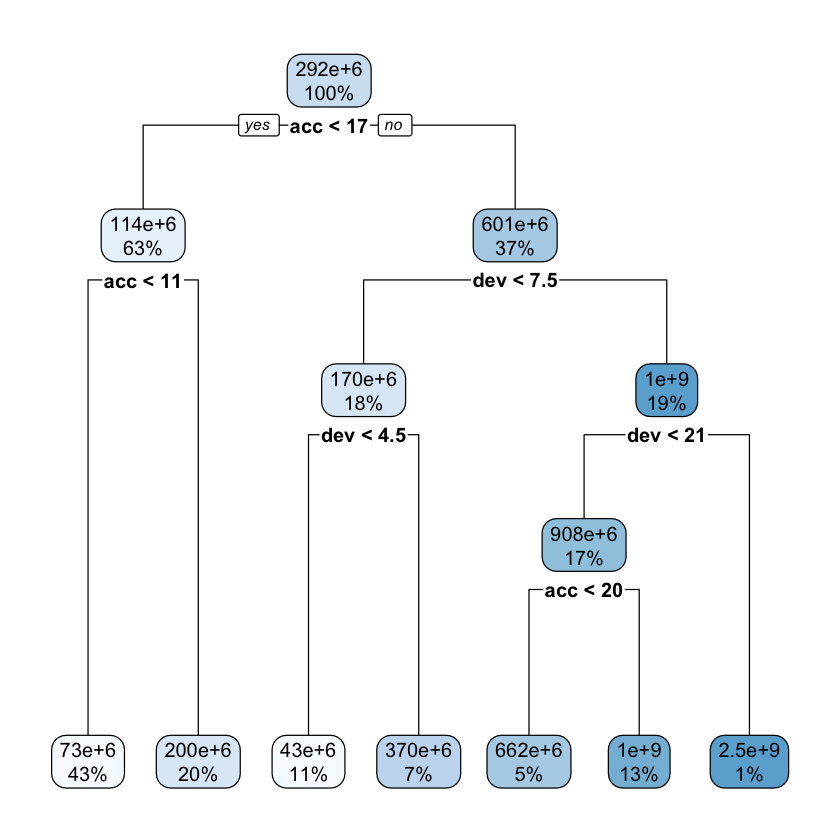

In [20]:
# create a learner, ie a container for a decision tree model
lrn_rpart_default <- lrn("regr.rpart")

# fit the model on all the past data (ie where row_roles==use)
lrn_rpart_default$train(task)  

# Visualise the tree
rpart.plot::rpart.plot(lrn_rpart_default$model, roundint = FALSE)



If you are unfamiliar with decision tree diagrams, the model specifies that, for example, for accident years greater than 17, with development periods less than 7.5 (ie 7 or under) and less than 4.5, the predicted claim cost is $43m. 

While the tree is fairly simple, we do see splits for acc<17 and dev<21, which match the location of the interaction.

Here's a list of the parameters - the documentation on `rpart.control` will have more information.

In [21]:
lrn_rpart_default$param_set


<ParamSet>
                id    class lower upper nlevels        default value
 1:       minsplit ParamInt     1   Inf     Inf             20      
 2:      minbucket ParamInt     1   Inf     Inf <NoDefault[3]>      
 3:             cp ParamDbl     0     1     Inf           0.01      
 4:     maxcompete ParamInt     0   Inf     Inf              4      
 5:   maxsurrogate ParamInt     0   Inf     Inf              5      
 6:       maxdepth ParamInt     1    30      30             30      
 7:   usesurrogate ParamInt     0     2       3              2      
 8: surrogatestyle ParamInt     0     1       2              0      
 9:           xval ParamInt     0   Inf     Inf             10     0
10:     keep_model ParamLgl    NA    NA       2          FALSE      

Let's try tuning the `cp` and `minsplit` parameters.


### Tuning the decision tree

To set up the tuning we need to specify:

* The ranges of values to search over
* A resampling strategy (already have this - crossvalidation)
* An evaluation measure (this is RMSE)
* A termination criterion so searches don't go on for ever (our `evals_trm`)
* The search strategy (e.g. grid search, random search, etc - see, e.g., [this post](https://towardsdatascience.com/hyperparameter-tuning-a-practical-guide-and-template-b3bf0504f095) )

We first set ranges of values to consider for these using functionality from the **paradox** library.

In [22]:

tune_ps_rpart <- ps(
  cp = p_dbl(lower = 0.001, upper = 0.1),
  minsplit = p_int(lower = 1, upper = 10)
)

We can see what's going to be searched over if we specify a 5x5 grid

In [23]:
# to see what's searched if we set a grid of 5
rbindlist(generate_design_grid(tune_ps_rpart, 5)$transpose())

cp,minsplit
<dbl>,<int>
0.00100,1
0.00100,3
0.00100,5
0.00100,8
0.00100,10
0.02575,1
0.02575,3
0.02575,5
0.02575,8


Given we only have 25 points (in a grid of 5), we can easily evaluate every option so we'll use a grid search strategy.
In practice other search strategies may be preferable - e.g. a random search often gets similar results to a grid search, in a much smaller amount of time.
Another possible choice is Bayesian optimisation search.

So now we have everything we need to tune our hyper-parameters so we can set this up in **mlr3** now.

In [24]:

# create the hyper-parameter for this particular learner/model
instance_rpart <- TuningInstanceSingleCrit$new(
  task = task,
  learner = lrn("regr.rpart"),
  resampling = crossval,
  measure = measure,
  search_space = tune_ps_rpart,
  terminator = evals_trm
)


# create a grid-search tuner for a 5-point grid
tuner <- tnr("grid_search", resolution = 5)


Finally, we run the tuning on the `instance_rpart` space. 

In [25]:
# suppress log output for readability
lgr::get_logger("bbotk")$set_threshold("warn")
lgr::get_logger("mlr3")$set_threshold("warn")


tuner$optimize(instance_rpart) 

# restart log output
lgr::get_logger("bbotk")$set_threshold("info")
lgr::get_logger("mlr3")$set_threshold("info")


cp,minsplit,learner_param_vals,x_domain,regr.rmse
<dbl>,<int>,<list>,<list>,<dbl>
0.001,3,"0.000, 0.001, 3.000","0.001, 3.000",101583816


The parameters in the best fit may be accessed here:

In [26]:

instance_rpart$result_learner_param_vals


$xval
[1] 0

$cp
[1] 0.001

$minsplit
[1] 3

So we can now fit a final model to all the data using these optimised parameters.

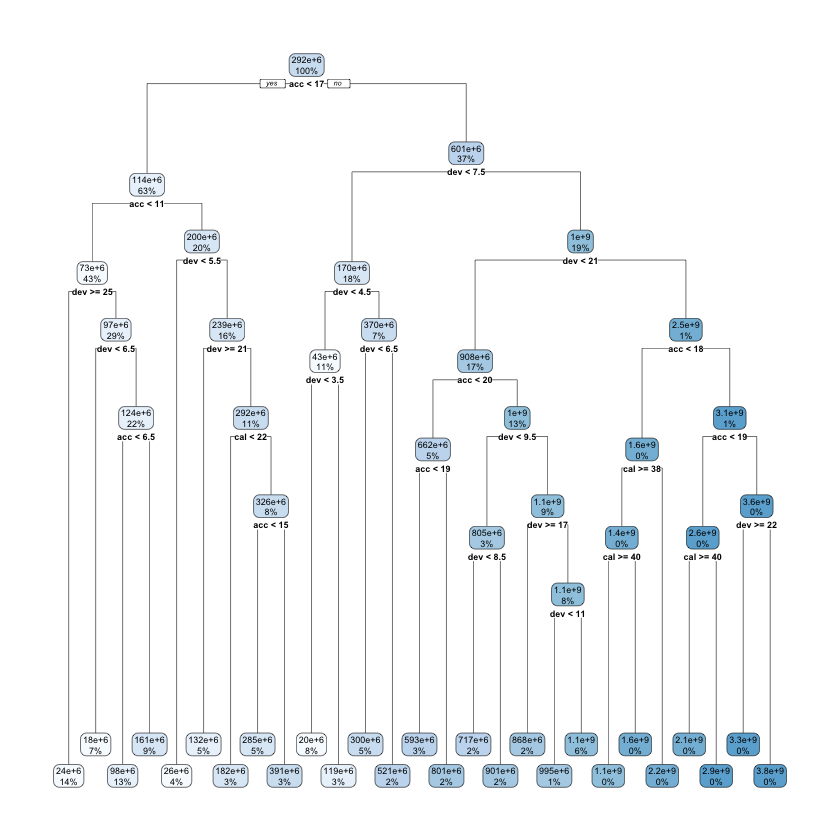

In [27]:

lrn_rpart_tuned <- lrn("regr.rpart")
lrn_rpart_tuned$param_set$values = instance_rpart$result_learner_param_vals
lrn_rpart_tuned$train(task)  

# plot the model
rpart.plot::rpart.plot(lrn_rpart_tuned$model, roundint = FALSE)



This model is much more complicated than the original and looks overfitted - we'll see if this is the case when we evaluate the model performance later in the article. 


## Random forest fitting

The **ranger** random forest package is implemented in **mlr3learners** (the regression version is `regr.ranger`).

Let's have a look at the hyper-parameters.



In [28]:

lrn("regr.ranger")$param_set


<ParamSet>
                              id    class lower upper nlevels        default
 1:                        alpha ParamDbl  -Inf   Inf     Inf            0.5
 2:       always.split.variables ParamUty    NA    NA     Inf <NoDefault[3]>
 3:                      holdout ParamLgl    NA    NA       2          FALSE
 4:                   importance ParamFct    NA    NA       4 <NoDefault[3]>
 5:                   keep.inbag ParamLgl    NA    NA       2          FALSE
 6:                    max.depth ParamInt  -Inf   Inf     Inf               
 7:                min.node.size ParamInt     1   Inf     Inf              5
 8:                     min.prop ParamDbl  -Inf   Inf     Inf            0.1
 9:                      minprop ParamDbl  -Inf   Inf     Inf            0.1
10:                         mtry ParamInt     1   Inf     Inf <NoDefault[3]>
11:            num.random.splits ParamInt     1   Inf     Inf              1
12:                  num.threads ParamInt     1   Inf     Inf    

Here, we'll try tuning number of trees (`num.trees`) and the minimum node size (`min.node.size`). `max.depth`, `mtry` and `sample.fraction` are also often helpful to tune.

We'll follow the same steps as for decision trees - set up a parameter space for searching, combine this with RMSE and cross-validation and then tune using grid search.


In [29]:

tune_ps_ranger <- ps(
  num.trees = p_int(lower = 100, upper = 900),
  min.node.size = p_int(lower = 1, upper = 5)
)

# to see what's searched if we set a grid of 5
#rbindlist(generate_design_grid(tune_ps_ranger, 5)$transpose())

instance_ranger <- TuningInstanceSingleCrit$new(
  task = task,
  learner = lrn("regr.ranger"),
  resampling = crossval,
  measure = measure,
  search_space = tune_ps_ranger,
  terminator = evals_trm
)

# suppress output
lgr::get_logger("bbotk")$set_threshold("warn")
lgr::get_logger("mlr3")$set_threshold("warn")

#We can reuse the tuner we set up for the decision tree
#this was tuner <- tnr("grid_search", resolution = 5)

tuner$optimize(instance_ranger) 

# turn output back on
lgr::get_logger("bbotk")$set_threshold("info")
lgr::get_logger("mlr3")$set_threshold("info")


num.trees,min.node.size,learner_param_vals,x_domain,regr.rmse
<int>,<int>,<list>,<list>,<dbl>
500,3,"1, 500, 3","500, 3",120597003


Get the best fit

In [30]:

instance_ranger$result_learner_param_vals


$num.threads
[1] 1

$num.trees
[1] 500

$min.node.size
[1] 3

Now we fit the model to all the parameters

In [31]:

lrn_ranger_tuned <- lrn("regr.ranger")
lrn_ranger_tuned$param_set$values = instance_ranger$result_learner_param_vals

lrn_ranger_tuned$train(task)  
lrn_ranger_tuned$model



Ranger result

Call:
 ranger::ranger(dependent.variable.name = task$target_names, data = task$data(),      case.weights = task$weights$weight, num.threads = 1L, num.trees = 500L,      min.node.size = 3L) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      820 
Number of independent variables:  3 
Mtry:                             1 
Target node size:                 3 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       14273383385093214 
R squared (OOB):                  0.9223578 

## XGBoost

Here are the XGBoost parameters.

In [32]:

# Can just run
# lrn("regr.xgboost")$param_set

# the code below just removes some of the columns for display purposes

kable_styling(
  kable(as.data.table(lrn("regr.xgboost")$param_set)[, .(id, class, default)]),
  full_width = FALSE) %>%
  as.character() %>%
  display_html()


id,class,default
booster,ParamFct,gbtree
watchlist,ParamUty,NULL
eta,ParamDbl,0.3
gamma,ParamDbl,0
max_depth,ParamInt,6
min_child_weight,ParamDbl,1
subsample,ParamDbl,1
colsample_bytree,ParamDbl,1
colsample_bylevel,ParamDbl,1
colsample_bynode,ParamDbl,1


With gradient boosting, it is often helpful to optimise over hyper-parameters, so we will vary some parameters and select the best performing set.
For speed reasons we will just consider `tweedie_variance_power`, `eta`, `max_depth` , and `nrounds` but in practice, we could consider doing more.

The steps are the generally same as before for decision trees and random forests.
However as we are searching over a greater number of parameters, we've switched to a random search to try to achieve better results.
Depending on your computer, this step takes a while to run (since our terminator is 500 evaluations) - so it might be a good point to grab a cup of coffee or tea! Alternatively reduce the number of evaluations in `eval_trm`.



In [33]:


tune_ps_xgboost <- ps(
  # ensure non-negative values
  objective = p_fct("reg:tweedie"),
  tweedie_variance_power = p_dbl(lower = 1.01, upper = 1.99),

  # eta can be up to 1, but usually it is better to use low eta, and tune nrounds for a more fine-grained model
  eta = p_dbl(lower = 0.01, upper = 0.3),
  # select value for gamma
  # tuning can help overfitting but we don't investigate this here
  gamma = p_dbl(lower = 0, upper = 0),
  
  # We know that the problem is not that deep in interactivity so we search a low depth
  max_depth = p_int(lower = 2, upper = 6),
  
  # nrounds to stop overfitting
  nrounds = p_int(lower = 100, upper = 500)
)

instance_xgboost <- TuningInstanceSingleCrit$new(
  task = task,
  learner = lrn("regr.xgboost"),
  resampling = crossval,
  measure = measure,
  search_space = tune_ps_xgboost,
  terminator = evals_trm
)

# need to make a new tuner with resolution 4
#tuner <- tnr("grid_search", resolution = 4)
set.seed(84)  # for random search for reproducibility
tuner <- tnr("random_search")

lgr::get_logger("bbotk")$set_threshold("warn")
lgr::get_logger("mlr3")$set_threshold("warn")

time_bef <- Sys.time()
tuner$optimize(instance_xgboost) 

lgr::get_logger("bbotk")$set_threshold("info")
lgr::get_logger("mlr3")$set_threshold("info")


Sys.time() - time_bef


objective,tweedie_variance_power,eta,gamma,max_depth,nrounds,learner_param_vals,x_domain,regr.rmse
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<list>,<list>,<dbl>
reg:tweedie,1.555728,0.1107844,0,4,467,"467 , 1 , 0 , reg:tweedie , 1.55572789821774 , 0.110784432103392, 0 , 4","reg:tweedie , 1.55572789821774 , 0.110784432103392, 0 , 4 , 467",80517695


Time difference of 31.50475 secs

Get the best fit:

In [34]:

instance_xgboost$result_learner_param_vals


$nrounds
[1] 467

$nthread
[1] 1

$verbose
[1] 0

$objective
[1] "reg:tweedie"

$tweedie_variance_power
[1] 1.555728

$eta
[1] 0.1107844

$gamma
[1] 0

$max_depth
[1] 4

However, remember that these results are from 25 evaluations only, and with 4 hyper-parameters, we'd really like to use more evaluations. The model above isn't a particularly good one

The table below shows the results we got from 500 evaluations along with the results we got in earlier development work for this article (the hyper-parameter tuning results are subject to randomness, first due to the specification of the cross-validation folds and second due to the random search). We'll use these when looking at the model.


In [35]:

xgb_res <- data.table(Hyperparameter=c("nrounds", "tweedie_variance_power", "eta", "gamma[fixed]", "max_depth"),
                      Evals500=as.character(c(265, 1.011768, 0.2310797, 0, 3)),
                      Best=as.character(c(233, 1.01, 0.3, 0, 3)))


kable_styling(
  kable(xgb_res),
  full_width = FALSE) %>%
  as.character() %>%
  display_html()



Hyperparameter,Evals500,Best
nrounds,265,233
tweedie_variance_power,1.011768,1.01
eta,0.2310797,0.3
gamma[fixed],0,0
max_depth,3,3


We'll fit both models here:

* `lrn_xgboost_tuned` - the results found from running the tuning code with 500 evaluations
* `lrn_xgboost_prevtuned` - the best results we found in previous work


In [36]:
lrn_xgboost_prevtuned = lrn("regr.xgboost", objective="reg:tweedie", nrounds=233, 
                            tweedie_variance_power=1.01, eta=0.3, gamma=0, max_depth=3)
lrn_xgboost_prevtuned$train(task)


lrn_xgboost_tuned = lrn("regr.xgboost", objective="reg:tweedie", nrounds=265, 
                            tweedie_variance_power=1.011768, eta=0.2310797, gamma=0, max_depth=3)
lrn_xgboost_tuned$train(task)



If, instead, you would like to fit the XGBoost model found after 25 evaluations, you can use the code below to pick up the selected values after tuning. This replaces the model fitted above using the hyper-parameters found after 500 evaluations.

In [37]:
lrn_xgboost_tuned = lrn("regr.xgboost")
lrn_xgboost_tuned$param_set$values = instance_xgboost$result_learner_param_vals
lrn_xgboost_tuned$train(task)


We haven't run this code so our `lrn_xgboost_tuned` uses the 500 evaluations results.

## Consolidate results

Now we will consolidate results for these models. We will gather together:

* RMSE for past and future data
* predictions for each model.

Note that **mlr3** has various benchmarking tools which we haven't used here - partially because we want to focus on the concepts rather than the code and partially because we want to compare the results to a couple of other models not fitted in the same framework. If you're interested in learning more then the section on [benchmarking](https://mlr3book.mlr-org.com/benchmarking.html) in the mlr3 book is a good start. 
[Pipelines](https://mlr3book.mlr-org.com/pipelines.html) offer more flexible functionality too.

First, we'll set up a data.table to hold the model projections for each model and populate these projections for each model

In [38]:
# make a new copy of the data, deleting the row_id, accf and devf columns
model_forecasts <- copy(dat)[, c("row_id", "accf", "devf") := NULL]

# add the model projections - specify list of learners to use and their names
lrnrs <- c(lrn_rpart_tuned, lrn_ranger_tuned, lrn_xgboost_tuned, lrn_xgboost_prevtuned)

# the id property is used to name the variables - since we have 2 xgboosts, adjust id where necessary
lrn_xgboost_prevtuned$id <- "regr.xgboost_prev"


for(l in lrnrs){
  #learner$predict(task, row_ids) is how to get predicted values, returns 3 cols with preds in response
  # use row_ids to tell it to use entire data set, ie "use" and validation rows
  #model_forecasts[, (nl) := l$predict(task, row_ids=1:nrow(dat))$response]
  
  model_forecasts[, l$id := l$predict(task=task, row_ids=1:nrow(dat))$response]
}

tail(model_forecasts)



pmts,acc,dev,cal,mu,train_ind,regr.rpart,regr.ranger,regr.xgboost,regr.xgboost_prev
<dbl>,<int>,<int>,<int>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
125261750,40,35,74,109039367,FALSE,3276251556,1039427724,2161421312,180676800
62657370,40,36,75,82853302,FALSE,3276251556,1039394694,1662855296,97294160
63467681,40,37,76,62682720,FALSE,3276251556,1039474983,2963930368,228004720
26041979,40,38,77,47227843,FALSE,3276251556,1039475232,1337462528,201791488
33947274,40,39,78,35444881,FALSE,3276251556,1039563647,458035488,97800608
37258687,40,40,79,26503298,FALSE,3276251556,1039497978,458035488,97800608


Before we do any analysis, let's fit a couple more models to compare these results against:

* a Chainladder model
* a LASSO model


## Chainladder - the baseline model

Since this is a traditional triangle, it seems natural to compare any results to the Chainladder result. So here, we will get the predicted values and reserve estimate for the Chain ladder model.

It's important to note that we will just use a volume-all Chainladder (i.e. include all periods in the estimation of the development factors) and will not attempt to impose any judgement over the results. In practice, of course, models like the Chainladder are often subject to additional analysis, reasonableness tests and manual assumption selections, so it's likely the actual result would be different, perhaps significantly, from that returned here.

At the same time, no model, whether it be the Chainladder, or a more sophisticated ML model should be accepted without further testing, so on that basis, comparing Chainladder and ML results without modification is a reasonable thing to do. Better methods should require less human intervention to return a reasonable result.


### Getting the Chainladder reserve estimates

The Chainladder reserve can also be calculated using a GLM with:

* Accident and development factors
* The Poisson or over-dispersed Poisson distribution
* The log link.

We've used this method here as it's easy to set up in R but practical work using the Chain ladder may be better done with a package like the [R ChainLadder package](https://cran.r-project.org/web/packages/ChainLadder/index.html).

The easiest way to do this is to work outside **mlr3** and use the `glm()` function directly - this is because our mlr3 `task` doesn't contain `accf` and `devf`. 

Here's the code using `glm()` and the `predict()` method to add predicted values into `model_forecasts`. 


In [39]:
cl <- glm(data=dat[train_ind==TRUE, .(pmts, accf, devf)], formula=pmts ~ accf + devf, family=quasipoisson(link="log"))
model_forecasts[, "regr.glm" := predict(cl, newdata=dat[, .(pmts, accf, devf)], type="response")]


It is possible to fit this in **mlr3** too - but as we need to create a new task, it's easier to fit it directly uisng `glm()` as above. However, we've included the **mlr3** code below for those who are interested. There's a good bit more code here since we need to set up a new task and a new learner. 

It isn't necessary to run this code (we haven't used it below) but if you do, the end result will be that it recalculates the `regr.glm` variable in the `model_forecasts` data.table.


In [40]:
#-------------------------------------
# create a task with the factor versions of acc and dev [accf and devf] as the only features
task_cl <- TaskRegr$new(id = "reserves",
                     backend = dat[, .(pmts, train_ind, row_id, accf, devf)],
                     target = "pmts")

task_cl$set_row_roles(dat[train_ind==FALSE, row_id], roles="validation")

task_cl$set_col_roles("row_id", roles="name")

# drop train_ind from the feature list
task_cl$col_roles$feature <- setdiff(task_cl$feature_names, "train_ind")  

task_cl


#-------------------------------------
# fit the GLM - no hyper-parameter tuning since we know exactly the type of model we want to fit

lrn_glm <- lrn("regr.glm", family="quasipoisson", link="log")
lrn_glm$train(task_cl)

summary(lrn_glm$model)


#-------------------------------------
# add the predicted values to model_forecasts in the same way as we did for the other models.

model_forecasts[, lrn_glm$id := lrn_glm$predict(task=task_cl, row_ids=1:nrow(dat))$response]



<TaskRegr:reserves> (820 x 3)
* Target: pmts
* Properties: -
* Features (2):
  - fct (2): accf, devf


Call:
stats::glm(formula = formula, family = structure(list(family = "quasipoisson", 
    link = "log", linkfun = function (mu) 
    log(mu), linkinv = function (eta) 
    pmax(exp(eta), .Machine$double.eps), variance = function (mu) 
    mu, dev.resids = function (y, mu, wt) 
    {
        r <- mu * wt
        p <- which(y > 0)
        r[p] <- (wt * (y * log(y/mu) - (y - mu)))[p]
        2 * r
    }, aic = function (y, n, mu, wt, dev) 
    NA, mu.eta = function (eta) 
    pmax(exp(eta), .Machine$double.eps), initialize = expression(
        {
            if (any(y < 0)) 
                stop("negative values not allowed for the 'quasiPoisson' family")
            n <- rep.int(1, nobs)
            mustart <- y + 0.1
        }), validmu = function (mu) 
    all(is.finite(mu)) && all(mu > 0), valideta = function (eta) 
    TRUE), class = "family"), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-24314.2   -2132.8    -165.5    2197.1   29768.4  

Co

## LASSO (regularised regression)

Finally, we will use the LASSO to fit a model. We are going to fit the same model as we did in our previous [post](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/f-lasso/). We'll include a bare-bones description of the model here. If you haven't seen it before, then you may want to just take the model as given and skip ahead to the next section. Once you've read this entire article you may then wish to read the post on the LASSO model to understand the specifics of this model.

The main things to note about this model are:

* Feature engineering is needed to produce continuous functions of accident / development / calendar quarters for the LASSO to fit.
* The blog post and related paper detail how to do this - essentially we create a large group of basis functions from the primary `acc`, `dev` and `cal` variables that are flexible enough to capture a wide variety of shapes.
* If we want to use **mlr3** to do this, then we need to create a task that contains these basis functions as features.
* Cross-validation can be done within the underlying LASSO package (**glmnet**) rather than via **mlr3**. This is what we've done here.

There's a reasonable amount of code to run this model, whether we use **mlr3** or not:

* We need to create all the basis functions
* **mlr3** only - we need to set up a task
* We need to train the model using **glmnet**'s cross-validation function, `cv_glmnet()`.
* We then need to predict using the values for a particular penalty setting (the regularisation parameter) - following the paper, we use the penalty value that leads to the lowest cross-validation error.

Since the blog post shows how to do this using **glmnet** directly, here we use some **mlr3** code to fit the model to show how it would work in **mlr3**. As with the Chainladder/GLM example, it's more efficient code-wise to do the fitting outside of **mlr3**.

### Basis functions

The first step is to create all the basis functions that we need. The functions below create the ramp and step functions needed (over 4000 of these!). The end result is a data.table of the original payments and all the basis functions. As noted above, all the details are in the blog post and paper.


In [41]:

#---------------------------
# linear spline function - used in data generation and in spline generation below
LinearSpline <- function(var, start, stop){
    pmin(stop - start, pmax(0, var - start))
}


# function to calculate scaling factors for the basis functions
# scaling is discussed in the paper
GetScaling <- function(vec) {
  fn <- length(vec)
  fm <- mean(vec)
  fc <- vec - fm
  rho_factor <- ((sum(fc^2))/fn)^0.5
}


# function to create the ramps for a particular primary vector
GetRamps <- function(vec, vecname, np, scaling){
  
  # vec = fundamental regressor
  # vecname = name of regressor
  # np = number of periods
  # scaling = scaling factor to use
  
  # pre-allocate the matrix to hold the results for speed/efficiency
  n <- length(vec)
  nramps <- (np-1)
  
  mat <- matrix(data=NA, nrow=n, ncol=nramps)
  cnames <- vector(mode="character", length=nramps)
  

  col_indx <- 0

  for (i in 1:(np-1)){
    col_indx <- col_indx + 1

    mat[, col_indx] <- LinearSpline(vec, i, 999) / scaling
    cnames[col_indx] <- paste0("L_", i, "_999_", vecname)
  }
  
  colnames(mat) <- cnames
  
  return(mat)
}


# create the step (heaviside) function interactions
GetInts <- function(vec1, vec2, vecname1, vecname2, np, scaling1, scaling2) {
  
  # pre-allocate the matrix to hold the results for speed/efficiency
  n <- length(vec1)
  nints <- (np-1)*(np-1)
  
  mat <- matrix(data=NA_real_, nrow=n, ncol=nints)
  cnames <- vector(mode="character", length=nints)
  

  col_indx <- 0

  for (i in 2:np){
    
    ivec <- LinearSpline(vec1, i-1, i) / scaling1
    iname <- paste0("I_", vecname1, "_ge_", i)
    
    if (length(ivec[is.na(ivec)]>0)) print(paste("NAs in ivec for", i))
    
    for (j in 2:np){
      col_indx <- col_indx + 1  
      mat[, col_indx] <- ivec * LinearSpline(vec2, j-1, j) / scaling2
      cnames[col_indx] <- paste0(iname, "xI_", vecname2, "_ge_", j)
      
      jvec <- LinearSpline(vec2, j-1, j) / scaling2
      if (length(jvec[is.na(jvec)]>0)) print(paste("NAs in jvec for", j))

    }
  }
  
  colnames(mat) <- cnames
  
  return(mat)

  
}

Now the functions are defined, we'll create a data.table of basis functions here which we'll use later when fitting the LASSO.
The `dat_plus` table will hold them.

In [42]:

# get the scaling values
rho_factor_list <- vector(mode="list", length=3)
names(rho_factor_list) <- c("acc", "dev", "cal")

for (v in c("acc", "dev", "cal")){
  rho_factor_list[[v]] <- GetScaling(dat[train_ind == TRUE, get(v)])
}


# main effects - matrix of values

main_effects_acc <- GetRamps(vec = dat[, acc], vecname = "acc", np = num_periods, scaling = rho_factor_list[["acc"]])
main_effects_dev <- GetRamps(vec = dat[, dev], vecname = "dev", np = num_periods, scaling = rho_factor_list[["dev"]])
main_effects_cal <- GetRamps(vec = dat[, cal], vecname = "cal", np = num_periods, scaling = rho_factor_list[["cal"]])
                             
main_effects <- cbind(main_effects_acc, main_effects_dev, main_effects_cal)


# interaction effects
int_effects <- cbind(
    GetInts(vec1=dat[, acc], vecname1="acc", scaling1=rho_factor_list[["acc"]], np=num_periods, 
            vec2=dat[, dev], vecname2="dev", scaling2=rho_factor_list[["dev"]]),

    GetInts(vec1=dat[, dev], vecname1="dev", scaling1=rho_factor_list[["dev"]], np=num_periods, 
            vec2=dat[, cal], vecname2="cal", scaling2=rho_factor_list[["cal"]]),
    
    GetInts(vec1=dat[, acc], vecname1="acc", scaling1=rho_factor_list[["acc"]], np=num_periods, 
            vec2=dat[, cal], vecname2="cal", scaling2=rho_factor_list[["cal"]])
)


varset <- cbind(main_effects, int_effects)


# drop any constant columns over the training data set
# do this by identifying the constant columns and dropping them
varset_train <- varset[dat$train_ind, ]

rm_cols <- varset_train[, apply(varset_train, MARGIN=2, function(x) max(x, na.rm = TRUE) == min(x, na.rm = TRUE))]
varset <- varset[, !(colnames(varset) %in% colnames(rm_cols))]

# now add these variables into an extended data object
# remove anything not used in modelling
dat_plus <- cbind(dat[, .(pmts, train_ind, row_id)], varset)



### mlr3 setup for LASSO

First we need to set up a task. This differs from the tree-based models task as follows in that the input variables are all the basis functions we created and not the raw accident / development / calendar quarter terms - the `dat_plus` data.table.

Also we don't need to set up a cross-validation resampling for this task since the **glmnet** package has in-built cross-validation.

In [43]:

task_lasso <- TaskRegr$new(id = "reserves_lasso", backend = dat_plus, target = "pmts")

# sort out row and column roles
task_lasso$set_row_roles(dat[train_ind==FALSE, row_id], roles="validation")

# turn row_id into a name
task_lasso$set_col_roles("row_id", roles="name")

# drop train_ind from the feature list
task_lasso$col_roles$feature <- setdiff(task_lasso$feature_names, "train_ind")  


### Model fitting

As noted above, the **glmnet** package has an inbuilt cross-validation function to fit LASSO models so we'll use that rather than running cross validation via **mlr3**. We'll use a Poisson distribution so the cross-validation will look to minimise the Poisson deviance.

The results will not be identical to those in the paper - that used 8-fold cross-validation and, even if the number of folds were the same, the random number seeds will be different, so the composition of the folds would be different.


In [44]:
use_pmax  <- num_periods^2   # max number of variables ever to be nonzero
use_dfmax <- num_periods*10  

set.seed(777)  # for reproducibility

# create the mlr3 learner
lrn_cv_glmnet <- lrn(
    "regr.cv_glmnet", 
    family = "poisson",   
    nfolds = 6,
    thresh = 1e-08, 
    lambda.min.ratio = 0,
    # additional parameter for mlr3 - means that the model used when predicting is the min CV error model rather than default 1se model
    s="lambda.min",   
    dfmax = use_dfmax, 
    pmax = use_pmax, 
    alpha = 1, 
    standardize = FALSE, 
    maxit = 200000)    

# train the model
lrn_cv_glmnet$train(task_lasso)


The `s` parameter requires a little more explanation. The `regr.cv_glmnet` learner (which uses the `cv_glmnet()` function) fits models for many different possible penalty values (termed the `lambda` vector). For each of these, the average error is calculated across all folds. These are then plotted (together with error bars in the special plot created when we plot a `cv.glmnet` results object).


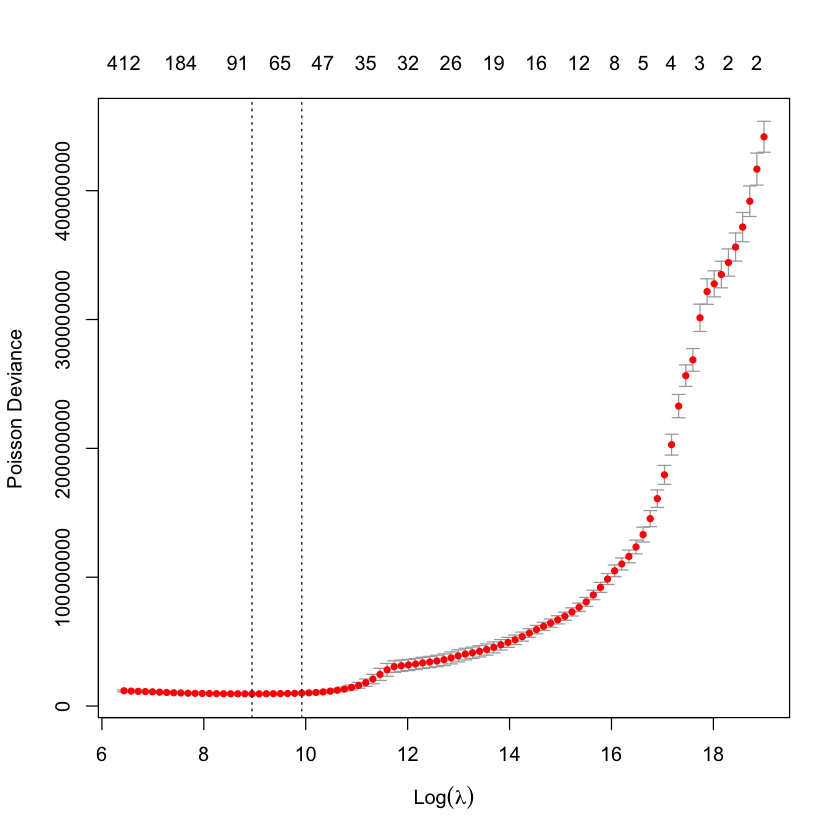

In [45]:
# Check the path includes a minimum value of error
plot(lrn_cv_glmnet$model)


The two dotted lines in this plot represent two special penalty (or `lambda` values):

* the `lambda.min` value - the penalty value which has the lowest cross-validation error (the left-most dotted line)
* the `lambda.1se` value - the penalty value where the cross-validation error is 1 standard error from the minimum value and the model is simpler (the right-most dotted line).

These names come from the **glmnet** package - `cv.glmnet` objects include these values. It's important to check that a true minimum has been found - if the left-most line (the `lambda.min` value) is the final value where the penalty is lowest, this suggests that the `lambda` vector needs to be lengthened and have smaller values than the current minimum. It's possible to supply a user-defined vector of penalty values in this case.

When working directly with **glmnet** we can easily access the model corresponding to any parameter value. When using `regr.cvglmnet ` in **mlr3**, we need to specify which penalty value to use for predictions. By default, the **mlr3** `predict` method uses `lambda.1se`, so we specify `s="lambda.min"` to use the `lambda.min` value as in the LASSO blog post.

Now we add the predictions to the `model_forecasts` table.

In [46]:
model_forecasts[, lrn_cv_glmnet$id := lrn_cv_glmnet$predict(task_lasso, row_ids = 1:nrow(dat))$response]

# Model analysis

This is the interesting bit - let's look at all the models to see how they've performed (but remember not to draw too many conclusions about model performance from this example as discussed earlier!)

Before we go any further though, we will make a long version of the data set (1 model result per row) as that will make a lot of calculations easier.
data.table has a `melt` method for doing this. Tidyverse users may be more familiar with `pivot_longer()` which also does the same thing.

In [47]:
# get list of variables to form observations by - this is why we used a common naming structure
model_names <- names(model_forecasts)[ names(model_forecasts) %like% "regr"]

# wide -> long
model_forecasts_long <- melt(model_forecasts, 
                             measure.vars = model_names, 
                             id.vars=c("acc", "dev", "cal", "pmts", "train_ind"))

# rename columns
setnames(model_forecasts_long, c("variable", "value"), c("model", "fitted"))

kable(head(model_forecasts_long)) %>%
  as.character() %>%
  display_html()

acc,dev,cal,pmts,train_ind,model,fitted
1,1,1,242671.2,TRUE,regr.rpart,18315018
1,2,2,164001.3,TRUE,regr.rpart,18315018
1,3,3,3224477.8,TRUE,regr.rpart,18315018
1,4,4,3682530.8,TRUE,regr.rpart,18315018
1,5,5,10149368.6,TRUE,regr.rpart,18315018
1,6,6,28578274.7,TRUE,regr.rpart,18315018


In [48]:
kable(tail(model_forecasts_long)) %>%
  as.character() %>%
  display_html()

acc,dev,cal,pmts,train_ind,model,fitted
40,35,74,125261750,FALSE,regr.cv_glmnet,193852526
40,36,75,62657370,FALSE,regr.cv_glmnet,216713451
40,37,76,63467681,FALSE,regr.cv_glmnet,276806762
40,38,77,26041979,FALSE,regr.cv_glmnet,353563580
40,39,78,33947274,FALSE,regr.cv_glmnet,451604592
40,40,79,37258687,FALSE,regr.cv_glmnet,576831775


Here's a reminder on the model names:

* `regr.glm` - Chainladder 
* `regr.cv_glmnet` - LASSO 
* `regr.rpart` - decision tree
* `regr.ranger` - random forest
* `regr.xgboost` and `regr.xgboost_prev` - the two XGBoost models.

## RMSE

As discussed above, we are going to do these calculations manually rather than use the **mlr3** benchmark tools because we want to include the Chainladder and LASSO models as well (even though we've fitted them here using **mlr3**, we used separate tasks). In any case the calculations are easy to do in **data.table** (for those who know that package anyway!) and it can be helpful to see what's going on..

For those who are unfamiliar, we've used a feature of data.table called chaining (similar in many ways to using the `%>%` pipe, or the newly introduced base R pipe, `|>`). The code does the following:

* the first line calculates `(fitted-pmts)^2` for each row of the long table (the squared error contribution)
* the second line sums up all these contributions grouped by `model` and by `train_ind`. It also gets the count of values
* the third line calculates the RMSE as the square root of these average contributions


In [49]:

model_rmse <- model_forecasts_long[, se_contrib := (fitted-pmts)^2
                                   ][, .(se_contrib = sum(se_contrib), num = .N), by=.(model, train_ind)
                                     ][, rmse := sqrt(se_contrib / num)]

head(model_rmse)


model,train_ind,se_contrib,num,rmse
<fct>,<lgl>,<dbl>,<int>,<dbl>
regr.rpart,TRUE,3307128991724779520,820,63506568
regr.rpart,FALSE,2864339162983414890496,780,1916306264
regr.ranger,TRUE,3609895529046446080,820,66349918
regr.ranger,FALSE,494621578124144345088,780,796322942
regr.xgboost,TRUE,803800528423931520,820,31308857
regr.xgboost,FALSE,764311151872238288896,780,989891960


Let's have a look at these results separately for past and future data sets with results ranked.

**Past data - train_ind == TRUE**

In [50]:

kable_styling(
  kable(model_rmse[train_ind==TRUE, .(model, num, rmse)][order(rmse),],
        digits=0,
        format.args = list(big.mark = ",", scientific = FALSE)),
  full_width = FALSE) %>%
  as.character() %>%
  display_html()




model,num,rmse
regr.xgboost_prev,820,"30,264,940"
regr.xgboost,820,"31,308,857"
regr.cv_glmnet,820,"46,966,367"
regr.rpart,820,"63,506,568"
regr.ranger,820,"66,349,918"
regr.glm,820,"138,528,927"


On the training data, all the tuned models perform reasonably well, with the XGBoost models having the lowest RMSE, followed by the LASSO model.
Unsurprisingly, the Chainladder model (regr.glm) has high RMSE - we know that these data will not be well modelled by a Chain ladder.

However, the key indicator is performance on a hold-out data set, in this case the future data.

**Future data - train_ind == FALSE**

In [51]:

kable_styling(
  kable(model_rmse[train_ind==FALSE, .(model, num, rmse)][order(rmse),],
        digits=0,
        format.args = list(big.mark = ",", scientific = FALSE)),
  full_width = FALSE) %>%
  as.character() %>%
  display_html()




model,num,rmse
regr.cv_glmnet,780,"251,388,945"
regr.xgboost_prev,780,"322,701,619"
regr.ranger,780,"796,322,942"
regr.xgboost,780,"989,891,960"
regr.glm,780,"1,722,472,390"
regr.rpart,780,"1,916,306,264"


For the future data, we see a very different story. As expected, the tuned decision tree does appear to be over-fitted - it performs poorer than the default decision tree. The LASSO model is the best, followed by the previously tuned XGBoost model. Despite having similar hyper-parameters, the two XGBoost models perform differently.



## Visualising the fit

Although useful, the RMSE is just a single number so it's helpful to visualise the fit.
In particular, because these are models for a reserving data set, we can take advantage of that structure when analysing how well each model is performing.

### Fitted values

First, lets show visualise the fitted payments.
The graphs below show the log(fitted values), or log(payments) in the case of the actual values.


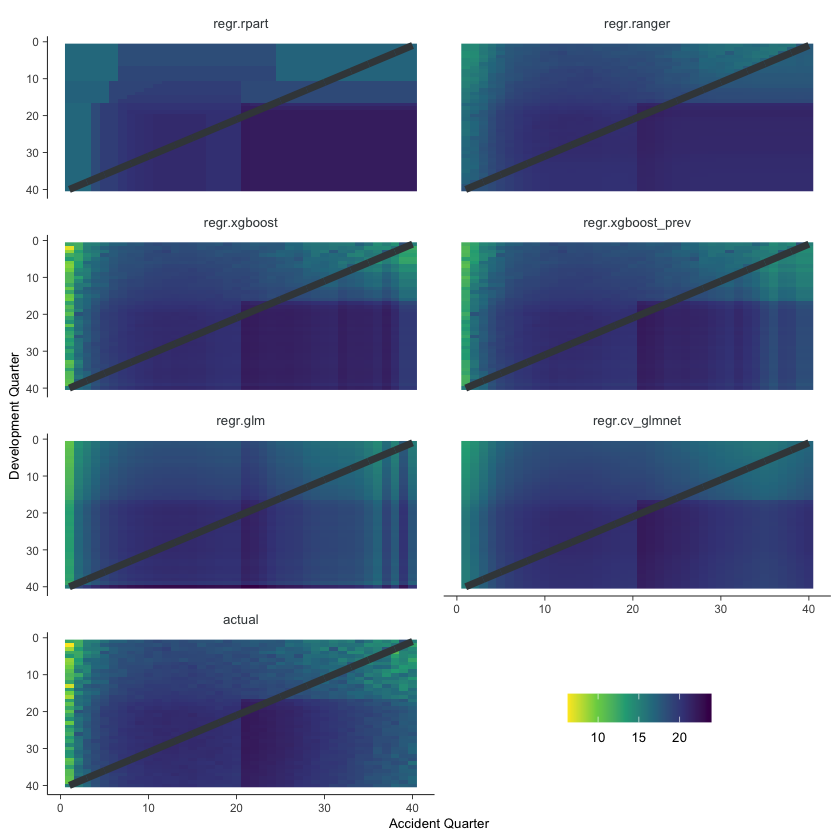

In [52]:


# add in the actual values for comparison
actuals <- model_forecasts_long[model=="regr.glm",]
actuals[, model := "actual"
        ][, fitted := pmts]
          
model_forecasts_long_plot <- rbind(actuals, model_forecasts_long)

# calculate log_fitted
model_forecasts_long_plot[, log_fitted := log(pmax(1, fitted))]

# plot
ggplot(model_forecasts_long_plot, aes(dev, acc)) +
  scale_y_reverse() +
  geom_raster(aes(fill = log_fitted)) +
  facet_wrap(~model, ncol=2)+
  scale_fill_viridis_c(begin=1, end=0) +
  geom_line(aes(x=num_periods+1-acc, y=acc), colour=dgrey, size=2)+
  theme_classic()+
  theme(strip.text = element_text(size=8,colour=dgrey), strip.background = element_rect(colour="white", fill="white"))+
  theme(axis.title.x = element_text(size=8), axis.text.x  = element_text(size=7))+
  theme(axis.title.y = element_text(size=8), axis.text.y  = element_text(size=7))+
  theme(element_line(size=0.25, colour=dgrey))+
  theme(legend.position=c(0.75, 0.1), legend.direction = "horizontal", legend.title=element_blank(), legend.text=element_text(size=8))+
  labs(x="Accident Quarter", y="Development Quarter")+
  NULL


Some things are apparent from this:

* The lack of interactions or diagonal effects in the Chain ladder (regr.glm)
* All the machine learning models do detect and project the interaction
* The blocky nature of the decision tree (regr.rpart) and the overfit to the past data
* The random forest (regr.ranger) and XGBoost fit look smoother since they are a function of a number of trees.
* The LASSO fit (regr.cv_glmnet) is the smoothest, which is not surprising since it consists of continuous functions.
* Visually, the LASSO seems to capture the interaction the best.


### Actual vs Fitted heat maps

We can also look at the model fits via heat maps of the actual/fitted values.
The function defined below calculates the actual/fitted values, capping and collaring them at 400% and 25%.
The values are then shaded so that:

* Dark blue = 25%
* White = 100%
* Dark red = 400%

For triangular reserving data, these types of plots are very helpful when examining plot fit.

First, here's a function to draw the heatmaps.

In [53]:

# heat maps

GraphHeatMap <- function(dat, x="dev", y="acc", facet="model", actual, fitted, lims=c(0.25, 4),
                         xlab="Development quarter", ylab="Accident Quarter"){
  
  # copy data to avoid modifying original
  localdat <- copy(dat)
  
  # get fails if there is a variable with the same name so make local copies
  local_x <- x
  local_y <- y
  local_actual <- actual
  local_fitted <- fitted
  
  # make restricted Avs F for heatmap and set up past/future split line
  np <- max(localdat[[y]])
  
  localdat[, .avsf := get(local_actual) / get(local_fitted)
           ][, .avsf_restrict_log := log(pmax(min(lims), pmin(max(lims), .avsf)))
             ][, .past_line := np + 1 - get(local_y)]
  
  
  g <- ggplot(data=localdat, aes_string(x=local_x, y=local_y)) +
    geom_tile(aes(fill = .avsf_restrict_log))+scale_y_reverse()+
    facet_wrap(~get(facet), ncol=2)+
    theme_classic()+
    scale_fill_gradient2(name="AvF_min", low=mblue, mid="white", high=red, midpoint=0, space="Lab", na.value="grey50", guide="colourbar")+
    labs(x=xlab, y=ylab)+
    geom_line(aes_string(x=".past_line", y=local_y), colour=dgrey, size=2)+
    theme(strip.text = element_text(size=8,colour="grey30"), strip.background = element_rect(colour="white", fill="white"))+
    theme(axis.title.x = element_text(size=8), axis.text.x  = element_text(size=7))+
    theme(axis.title.y = element_text(size=8), axis.text.y  = element_text(size=7))+
    theme(element_line(size=0.25, colour="grey30"))+
    theme(legend.position="none", )+  # legend.direction = "horizontal", legend.title=element_blank(), legend.text=element_text(size=8)
    NULL    
  

  invisible(list(data=localdat, graph=g))
  

}


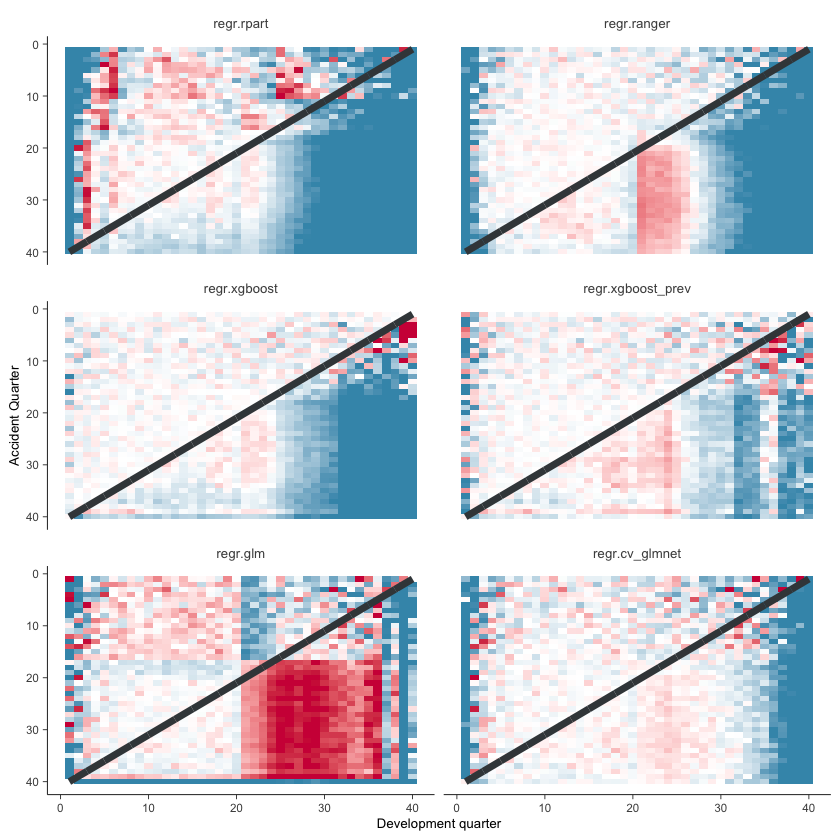

In [54]:

g <- GraphHeatMap(model_forecasts_long, x="dev", y="acc", facet="model", actual="pmts", fitted="fitted")
g$graph


All models have shortcomings, but the LASSO and previously tuned XGBoost models outperform the others. 


### Quarterly tracking

Finally, we will look at the predictions for specific parts of the data set.
Quarterly tracking graphs:

* Plot the actual and fitted payments, including future values, by one of accident / development / calendar period
* Hold one of the other triangle directions fixed, meaning that the third direction is then determined.
* Additionally plot the underlying mean from which the data were simulated.

We'll use a couple of functions because we want to do this repeatedly.

The first function (`GraphModelVals`) is from the blog on the LASSO model, and draws a single tracking graph.
The second function (`QTracking`) generates the graphs for all models and uses the **patchwork** package to wrap them into a single plot.



In [55]:


GraphModelVals<-function(dat, primary_predictor, secondary_predictor, secondary_predictor_val, 
                         xaxis_label, yaxis_label, var_names, log_values = TRUE, include_st=FALSE, include_legend=FALSE, font_size=6){


  # var_names must be list with names like this: list(actual="pmts", mean="mu", fitted="fitted")
  
  # extract data we want to use
  use_dat <- dat[get(secondary_predictor) == secondary_predictor_val, ]
  
  # turn into long format using melt.data.table since that works better with ggplot
  dat_long <- melt(dat[get(secondary_predictor) == secondary_predictor_val, ],
                   measure.vars = unlist(var_names),
                   id.vars = primary_predictor)
  
  # make the names nicer - colnames and labels
  setnames(dat_long, primary_predictor, "predictor")
  
  dat_long[variable == var_names$actual, variable := "Simulated"
           ][variable == var_names$mean, variable := "Underlying"
             ][variable == var_names$fitted, variable := "Fitted"]
  
  # get the levels of the variables right so that they are plotted in the right order
  dat_long[, variable := factor(variable, levels=c("Fitted", "Simulated", "Underlying"))]
  
  
  if (log_values) dat_long[, value := log(value)]
  
  # figure out past data rectangle coordinates
  xmin1 <- use_dat[train_ind == TRUE, min(get(primary_predictor))]
  xmax1 <- use_dat[train_ind == TRUE, max(get(primary_predictor))]
  
  ymin1 <- dat_long[, min(value)]*0.95
  ymax1 <- dat_long[, max(value)]*1.05
  
  
  # draw the tracking plots
  g <- ggplot(data=dat_long, aes(x=predictor, y=value, group=variable))+
    geom_line(aes(linetype=variable, colour=variable, size=variable, alpha=variable))+
    geom_line(aes(linetype=variable, colour=variable))+
    scale_colour_manual(name="", values=c(red, dgrey, dgrey))+
    scale_linetype_manual(name="", values=c("solid", "solid", "dotted"))+
    scale_size_manual(name="", values=c(2,1,1))+
    scale_alpha_manual(name="", values=c(0.8, 0.5, 0.5))+
    theme_classic()+
    annotate(geom="rect", xmin=xmin1, xmax=xmax1, ymin=ymin1, ymax=ymax1, alpha=0.1)+
    labs(x=xaxis_label, y=yaxis_label, title=paste(xaxis_label, "tracking for", secondary_predictor, "=", secondary_predictor_val)) +
    theme(axis.title = element_text(size = font_size), axis.text = element_text(size = font_size-1))
         
  if(include_st==TRUE) g <- g + labs(subtitle="Past data in grey rectangle") + theme(plot.subtitle = element_text (size = font_size))

  g <- if(include_legend==TRUE) g + theme(legend.position=c(1.5, 0.5)) else g + theme(legend.position = "none")
  
  

  # return the results  
  invisible(list(data=dat_long, graph=g))
}



Let's have a look at the tracking for accident quarter when development quarter = 5.
We'll wrap this in another function since we want to call this for a few different combinations.

In [56]:

QTracking <- function(dat,
                      model_names,
                      primary_predictor,
                      secondary_predictor,
                      secondary_predictor_val,
                      xaxis_label,
                      yaxis_label = "Log(Payments)",
                      font_size = 8,
                      plots_ncol=2){

  # hold each plot
  tracking_g <- list()

  # produce each plot  
  for (model in model_names){
    
    # variable names in plot
    vn <- list(actual="pmts", mean="mu", fitted=model)
    
    # include subtitle or not in the graph (first plot only)
    bool_st <- if(model == model_names[1]) TRUE else FALSE
    
    # include legend or not in the graph (last plot only)
    bool_legend <- if(model == model_names[length(model_names)]) TRUE else FALSE
    
    # draw plot
    tracking_g[[model]] <- GraphModelVals(dat, 
                                          primary_predictor = primary_predictor, 
                                          secondary_predictor = secondary_predictor, 
                                          secondary_predictor_val = secondary_predictor_val, 
                                          xaxis_label = xaxis_label, 
                                          yaxis_label = yaxis_label, 
                                          var_names = vn, 
                                          include_st = bool_st, 
                                          include_legend = bool_legend,
                                          font_size = font_size)$graph +
      ggtitle(paste("Modelled values for", model)) + 
      theme (plot.title = element_text (size = (font_size+1)))
  }

  # use patchwork to wrap all plots into a single display  
  wrap_plots(tracking_g, ncol=2)
  
    
}


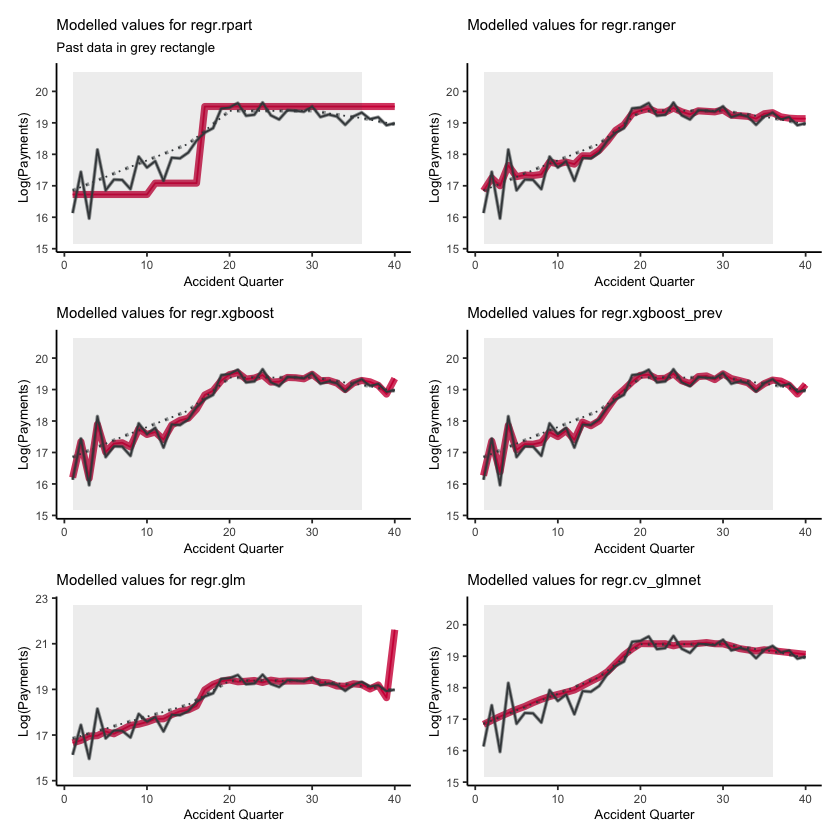

In [57]:
QTracking(model_forecasts,
          model_names = model_names,
          primary_predictor = "acc",
          secondary_predictor = "dev",
          secondary_predictor_val = 5,
          xaxis_label = "Accident Quarter")




Because this is mostly old data and because it is not affected by the interaction, the tracking should be generally good, even for the Chain ladder - which is the case (apart from the final quarter being a bit wild as can happen with a Chain ladder).
The decision tree model is poor, the random forest and XGBoost model show some evidence of overfitting. The LASSO model seems to strike the right balance.

Here are a few more tracking plots to help further illustrate the model fits.

**Tracking for accident quarter when development quarter = 24**

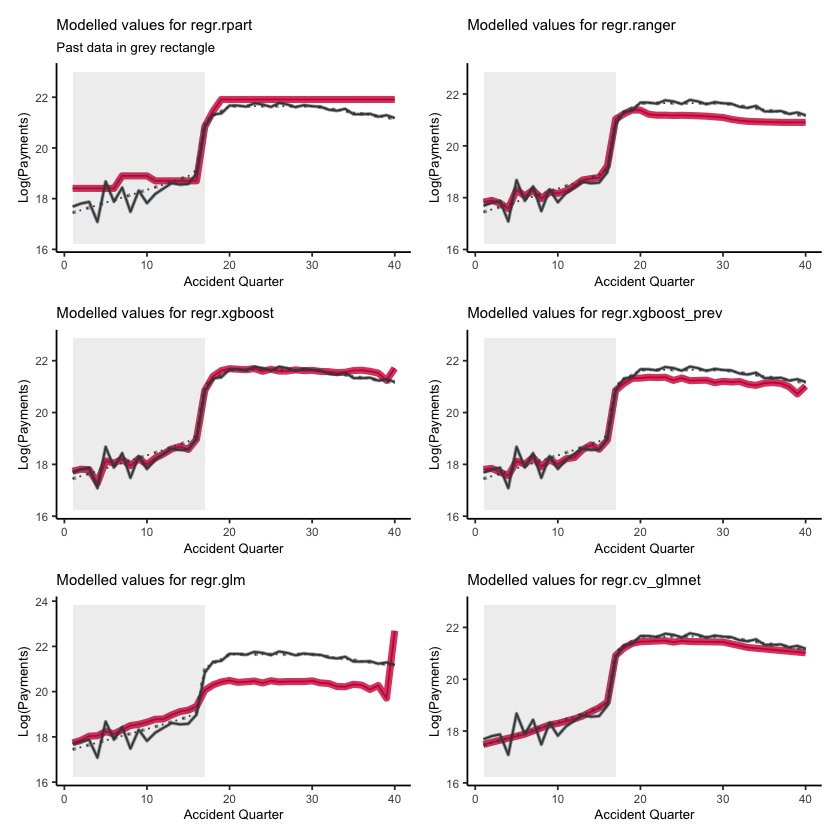

In [58]:

QTracking(model_forecasts,
          model_names = model_names,
          primary_predictor = "acc",
          secondary_predictor = "dev",
          secondary_predictor_val = 24,
          xaxis_label = "Accident Quarter")




Development quarter 24 is impacted by the interactions for accident quarters>17.
All models reflect this to different extents, with XGBoost and the LASSO doing the best.

**Tracking for accident quarter when development quarter = 35**


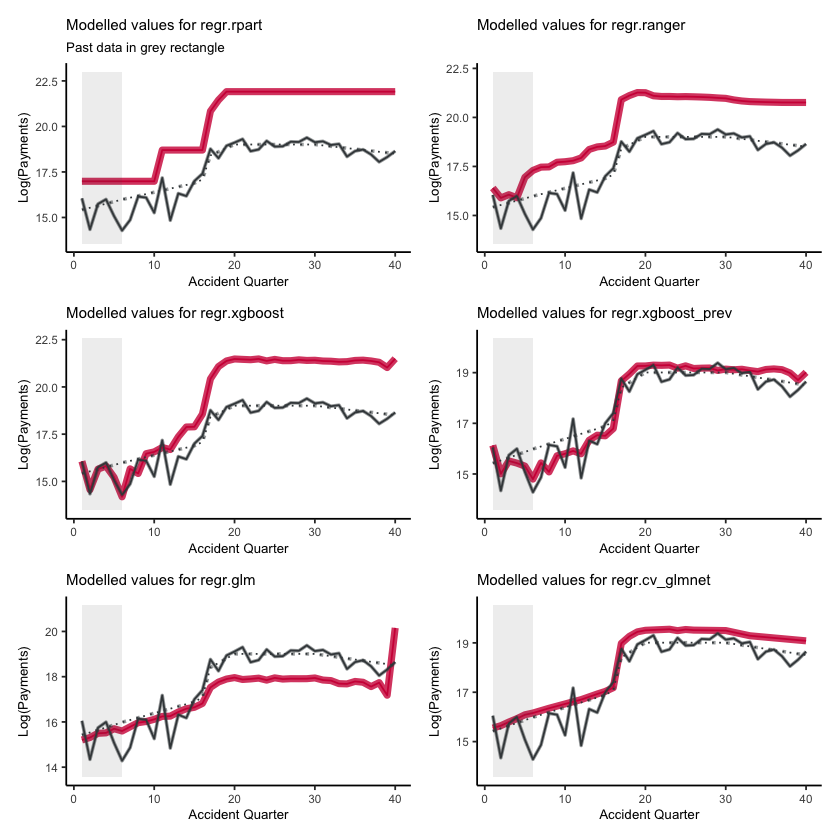

In [59]:

QTracking(model_forecasts,
          model_names = model_names,
          primary_predictor = "acc",
          secondary_predictor = "dev",
          secondary_predictor_val = 35,
          xaxis_label = "Accident Quarter")




This is quite hard for the models since most of the values are in the future. XGBoost (previously tuned) and the LASSO are the best here.

We can look at similar plots by development quarter for older and newer accident quarters

**Tracking for development quarter when accident quarter = 5**

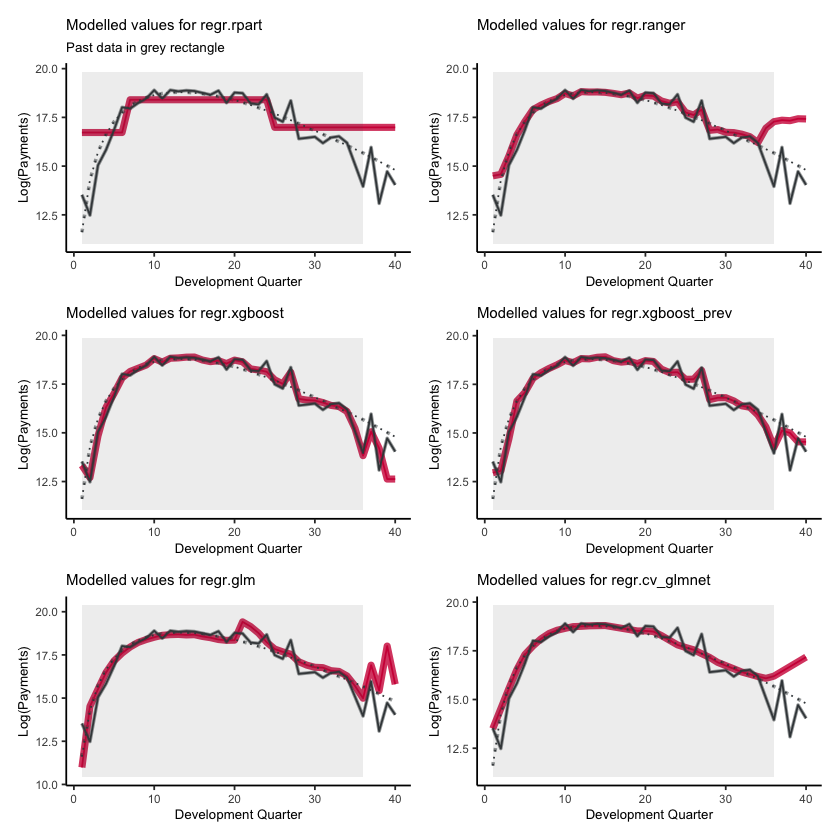

In [60]:

QTracking(model_forecasts,
          model_names = model_names,
          primary_predictor = "dev",
          secondary_predictor = "acc",
          secondary_predictor_val = 5,
          xaxis_label = "Development Quarter")


**Tracking for development quarter when accident quarter = 20**

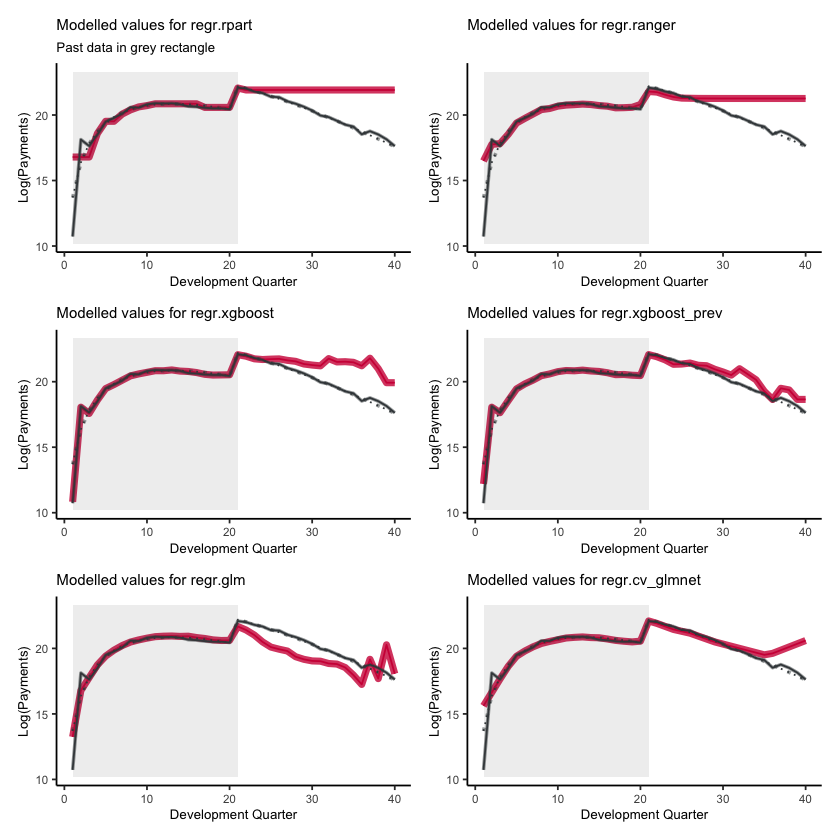

In [61]:

QTracking(model_forecasts,
          model_names = model_names,
          primary_predictor = "dev",
          secondary_predictor = "acc",
          secondary_predictor_val = 20,
          xaxis_label = "Development Quarter")


# Reserves

Finally, we'll look at the reserve estimates from the different models. For convenience, here's the mapping of model name to model type again:

* `regr.glm` - Chainladder 
* `regr.cv_glmnet` - LASSO 
* `regr.rpart` - decision tree
* `regr.ranger` - random forest
* `regr.xgboost` and `regr.xgboost_prev` - the two XGBoost models.


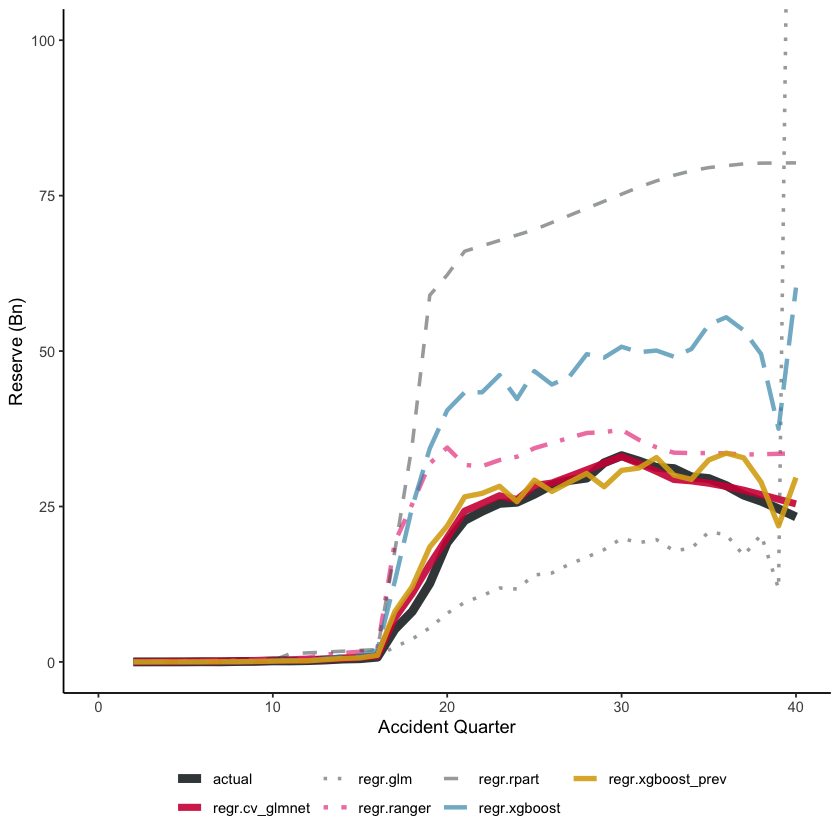

In [62]:

# summarise the future payments and each model projection by accident quarter
# remember ml is a character vector of all the model names, which are columns of
#   fitted values in model_forecasts

# get reserves and payments by accident quarter
os_acc <- model_forecasts_long[train_ind == FALSE, .(actual=sum(pmts)/1e9, reserve=sum(fitted)/1e9), by=.(model, acc)]

# make full tidy data set by stacking actuals
os_acc <- rbind(os_acc[model=="regr.glm",][, reserve := actual][, model := "actual"],
                os_acc)

# adjust levels of factor to ger correct ordering
os_acc[, model := factor(as.character(model), level=c("actual", "regr.cv_glmnet", "regr.glm", "regr.ranger", 
                                                      "regr.rpart", "regr.xgboost", "regr.xgboost_prev"))]

setkey(os_acc, model, acc)


# create a factor variable from model so we can order it in the plot as we wish
g1 <- ggplot(data=os_acc, aes(x=acc, y=reserve, group=model)) +
  geom_line(aes(linetype=model, colour=model, size=model, alpha=model))+
  scale_colour_manual(name="", values=c(dgrey, red, dgrey, fuscia, dgrey, mblue, gold))+
  scale_linetype_manual(name="", values=c("solid", "solid", "dotted", "dotdash", "dashed", "longdash", "solid"))+
  scale_size_manual(name="", values=c(2.5, 2, 1, 1.25, 1, 1.25, 1.5))+
  scale_alpha_manual(name="", values=c(1, 0.9, 0.5, 0.7, 0.5, 0.7, 0.9))+
  coord_cartesian(ylim=c(0, 100), xlim=c(0, 40))+
  theme_classic() +
  theme(legend.position = "bottom")+
  labs(y="Reserve (Bn)", x="Accident Quarter")+
  NULL

g1


Let's look at a zoomed in version of this plot.


Coordinate system already present. Adding new coordinate system, which will replace the existing one.



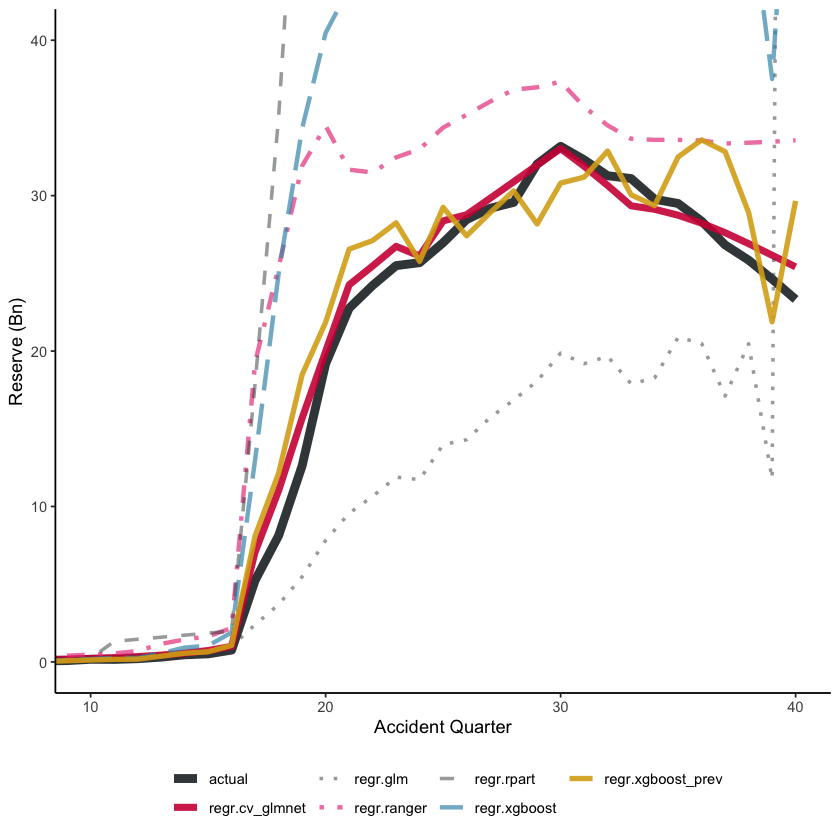

In [63]:

g1 + coord_cartesian(ylim=c(0, 40), xlim=c(10, 40))


Finally, here are the overall reserves, summed over all accident quarters

In [64]:

os <- os_acc[, .(reserve=sum(reserve), actual=sum(actual)), by=.(model)]
os[, ratio := 100*reserve / actual][, actual := NULL]


# sort
os[, ratio_diff := abs(ratio-100)]
os <- os[order(ratio_diff)][, ratio_diff := NULL]

# output table
setnames(os, c("model", "reserve", "ratio"), c("Model", "Reserve(Bn)", "Ratio to actual(%)"))
kable_styling( kable(os, digits=0, format.args = list(big.mark = ",", scientific = FALSE)),
               full_width = FALSE) %>%
  as.character() %>%
  display_html()



Model,Reserve(Bn),Ratio to actual(%)
actual,608,100
regr.cv_glmnet,628,103
regr.xgboost_prev,649,107
regr.glm,563,93
regr.ranger,804,132
regr.xgboost,"1,089",179
regr.rpart,"1,680",276


The best performers are the LASSO and the previously tuned XGBoost model.
The overall reserve for the Chainladder model (regr.glm) hides the fact that this result is actually significant under-estimation in most accident quarters balanced by significant over-estimation in the last.


# Commentary

What's going on with the XGBoost results?

As we noted when we fitted the XGBoost model, there are a few components of randomness from one run to another, with different seeds:

1. The cross validation folds will be different
2. The random search parameters will be different.

For a small data set like this one, this has the potential to alter the results - afterall, getting a good result on the future data depends on whether the tuning gets lucky in terms of estimating the magnitude of the interaction.

We could reduce the variability by uisng a grid-search over a fixed set of parameters but - full disclosure - that led to even worse results.

So what's going on?
It might be helpful to have another look at the folds used in the cross-validation.
These are shown below - the yellow dots represent training data points in each fold, the blue dots are the test data.
The grey rectangle marks the interaction.

In [65]:

# interaction x >= 17 && y >= 21

xydat <- data.table(acc = rep(1:num_periods, each = num_periods),
                    dev = rep(1:num_periods, times = num_periods),
                    row_id = 1:nrow(dat) )
                      
xydat[, past := TRUE][((acc+dev-1) > num_periods), past := FALSE]


# add first test and train data set
nf <- crossval$iters  # number of folds

for (i in 1:nf){
  tem <- rbind(
    data.table(row_id = (crossval$train_set(i)), train_ind = TRUE),
    data.table(row_id = (crossval$test_set(i)), train_ind = FALSE)
  )
  
  setkey(tem, row_id)
  
  nm <- paste0("fold", i)
  xydat[tem, on=.(row_id), (nm) := i.train_ind]
}


# drop the future data now
xydat <- xydat[past==TRUE,]


# make a long data set now so we can ggplot it
folds <- melt(xydat,
              measure.vars = paste0("fold", 1:nf),
              id.vars = c("acc", "dev"))





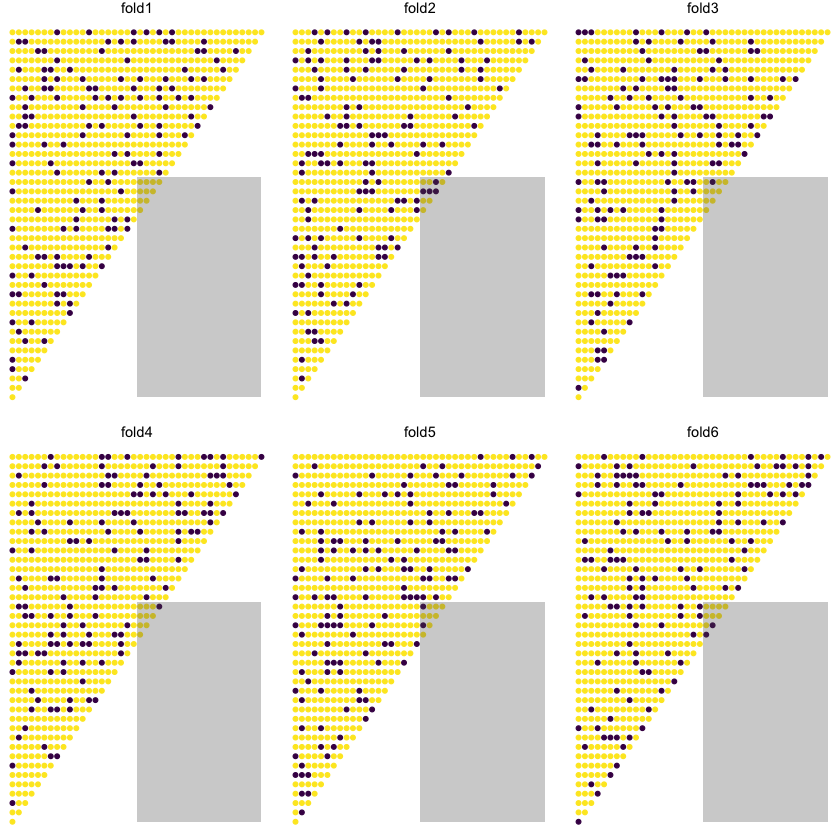

In [66]:

ggplot(data=folds, aes(x=dev, y=acc, colour=value)) +
  facet_wrap(~variable, ncol=3)+
  geom_point(size=1) +
  scale_colour_viridis_d() +
  annotate(geom="rect", xmin=20.5, xmax=40, ymin=16.5, ymax=40, alpha=0.3)+
  #scale_colour_manual(values=c("#73D055FF", "#404788FF")) +  # same colours as before
  scale_y_reverse() +
  theme_void() +
  theme(legend.position = "none") +
  NULL  



The first thing that is apparent is that the interaction only applies to a very small number of points (10) in the past data.
So in that sense, it's quite remarkable that the models perform as well as they actually do - they all detect the interaction.
Where they start to slip up is that they do not necessarily follow the development quarter shape in the tail.

With cross-validation, all points are in the test data set once and once only. 
So it seems to be the case that the particular allocation of data into folds in this notebook leads to poorer results for the XGBoost model.
In other words, in our previous tuning for XGBoost we got lucky.

So far, XGBoost seems to be the only model impacted in this way. Based on looking at a few different sets of results, the LASSO model has generally been good for different folds and for 5-, 6- and 8-fold validation. The performance of the ranger model doesn't appear to change all that much.

However, given XGBoost's popularity and flexibility, this result is not ideal.
The question is: can we improve matters?

Success in machine learning often comes down to optimising the following:

* What you model
* How you model (i.e. what features you use)
* Your performance measure
* Your train/test split.

Reserving is a forecasting problem - we have a time series of payments and we want to forecast into the future.
This suggests that cross-validation is not an ideal method for tuning reserving models - we would be better with a train/test split where the test data is in the future relative to the past data.

This problem has been discussed in the context of time series modelling, where the use of rolling window cross-validation techniques has been advocated. 
We'll be discussing this in a future article.

# Conclusion

We set out to demonstrate how to fit a number of reserving models to a data set.
Our results have been mixed - but we expected that in advance.
This work lays a baseline for our upcoming articles where we will look at ways of improving the results through:

* expanding the range of models
* considering more appropriate validation techniques.

## What next?

You can try running this code and changing some things - e.g. the hyper-parameters tuned, search strategy, number of iterations etc.

You can also try running the code for different data sets. It's best to initially work with data sets that are familiar to you, so your own data sets or other simulated data sets may be useful here. In the code block below, we've shared the code used to generate the data set we used. You can generate other data sets as described in the [LASSO paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3241906) using the code block below. More details are in the paper, but in brief:

* Data set 1 = a Chainladder model
* Data set 2 = a Chainladder model + calendar period effects
* Data set 3 = the data set used here
* Data set 4 = data set 2 but where the strength of the calendar period effect varies by development period.

In [67]:

library(data.table)

# this function generates the four different forms of data set as described in the LASSO paper

CreateSyntheticData<-function(whichsim, numperiods)
{
  
	# create the acc/dev/cal parameters
	kk <- rep(1:numperiods, each = numperiods) #AQ
	jj <- rep(1:numperiods, times= numperiods) #DQ
	tt <- kk+jj-1 # PQ

	# set alpha/beta/gamma - hard-code up the sim values
	if (whichsim == 1){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40) 
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj
		gamma <- 0
		mu <- exp( alpha + beta + gamma)  
	}
	else if (whichsim == 2){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40) 
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3 
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma)  
	}
	else if (whichsim == 3){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40) 
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3 
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma + 0.3*beta*ifelse(kk>16 & jj>20,1,0))  
	}
	else if (whichsim == 4){
		alpha <- log(100000)+0.1*LinearSpline(kk,1,15)+0.2*LinearSpline(kk,15,20) - 0.05*LinearSpline(kk,30,40) 
		beta  <- (16/3 - 1)*log(jj)- (1/3)*jj  # a is 16/3, b is 1/3 
		gamma <- gammafunc(tt)
		mu <- exp( alpha + beta + gamma*((numperiods-1)-LinearSpline(jj,1,numperiods))/(numperiods-1) )  # need to check
	}
	
	varbase <- (0.3 * mu[  kk==1 & jj ==16] )^2 # can scale variance up and down here
	CC  <-  varbase / mu[  kk==1 & jj ==16]
	
	vars   <- CC*mu
	tausq  <- log (vars / (mu^2) + 1)
	
	pmts <- exp( rnorm( numperiods^2, mean = log(mu)-0.5*tausq , sd = sqrt(tausq)  ) )
	
	# indicator for past/future = traint/test
	train_ind<-(tt<=numperiods)
	
	### data fram for output
	full<-data.table(pmts, acc=as.integer(kk), dev=as.integer(jj), cal=as.integer(tt), mu, train_ind )
	full
}


#---------------------------
# function to generate calendar period effects used in CreateSyntheticData()

gammafunc <- function(t){
	gg <- 
		ifelse( t<=12, gg <- 0.0075*LinearSpline(t,1,12),
				ifelse(t<=24,  gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (t-12)*(t-11)/2,
					   ifelse(t<=32, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2,
					   	   ifelse(t<=40, gg <- 0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(t-32)*(t-31)/2,
					   	   	   0.0075*LinearSpline(12,1,12) + 0.001* (24-12)*(24-11)/2 + 0.002*(40-32)*(40-31)/2
					   	   ))))
	1*gg  #can scale up shape here if desired
}



#---------------------------
# linear spline function - used in data generation and in spline generation below
# this was defined earlier on in this worked example, but including the definition here so it is self-contained
LinearSpline <- function(var, start, stop){
    pmin(stop - start, pmax(0, var - start))
}


#---------------------------
# How to run the code
# The code below, including the seed value, recreate the data we used above

# vary the seed to create different data sets of the same form
set.seed(130)  

# whichsim can be 1, 2, 3, 4 to produce data sets in the form above
# numperiods sets the dimensions of the triangle
dat <- CreateSyntheticData(whichsim = 3, numperiods = 40)




If you are looking for something more advanced, then have a look at our 3-part series on an advanced example where individual data and a number of different features are used in an XGBoost model. To find this follow the links:

* [Part 1](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/baudry-part1/) - data generation
* [Part 2](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/baudry-part2/) - data preparation
* [Part 3](https://institute-and-faculty-of-actuaries.github.io/mlr-blog/post/baudry-part3/) - modelling and analysis


# Session details

The details of the R session used to generate the results are below.


In [68]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS High Sierra 10.13.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] IRdisplay_1.0           kableExtra_1.3.4        rpart.plot_3.0.9       
 [4] rpart_4.1-15            patchwork_1.1.1         ggplot2_3.3.4          
 [7] data.table_1.14.0       mlr3extralearners_0.4.7 mlr3tuning_0.8.0       
[10] paradox_0.7.1           mlr3learners_0.4.5      mlr3_0.11.0            

loaded via a namespace (and not attached):
 [1] viridis_0.6.1        httr_1.4.2           jsonlite_1.7.2      
 [4] viridisLite_0.4.0    splines_4.1.0        foreach_1.5.1       
 [7] as